# Getting started with INTEGRATE

This notebook contains a simple example for getting started with INTEGRATE.

The workflow follows these main steps:
0. Load electromagnetic data (DAUGAARD.h5)
1a. Set up a prior model, creating the file PRIOR.h5
1b. Update the prior model with forward-modeled data in PRIOR.h5
2. Perform probabilistic inversion using integrate_rejection, creating POST.h5
3. Plot and analyze the results

In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # #%load_ext autoreload
    # # # # # # #%autoreload 2
    pass

In [2]:
import integrate as ig
# Check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)
hardcopy = True 
import matplotlib.pyplot as plt

Notebook detected. Parallel processing is OK


## 0. Get TTEM data
Several test cases are available in the INTEGRATE package.
To see which cases are available, check the `get_case_data` function.

The code below downloads the file DAUGAARD_AVG.h5 that contains 
TTEM (time-domain electromagnetic) soundings from Daugaard, Denmark.
It also downloads the corresponding GEX file, TX07_20231016_2x4_RC20-33.gex, 
which contains information about the TTEM system configuration and parameters.


In [3]:
case = 'DAUGAARD'
files = ig.get_case_data(case=case, showInfo=2)
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)

print("Using data file: %s" % f_data_h5)
print("Using GEX file: %s" % file_gex)




Getting data for case: DAUGAARD
File DAUGAARD_AVG.h5 already exists. Skipping download.
File TX07_20231016_2x4_RC20-33.gex already exists. Skipping download.
File README_DAUGAARD already exists. Skipping download.
--> Got data for case: DAUGAARD
Using data file: DAUGAARD_AVG.h5
Using GEX file: TX07_20231016_2x4_RC20-33.gex


### Plot the geometry and data
`ig.plot_geometry` plots the spatial geometry of the data (i.e., the locations of the soundings).
`ig.plot_data` plots the measured electromagnetic data for each sounding.

f_data_h5=DAUGAARD_AVG.h5
Plot size: wx=10.000000, wy=7.752841
f_data_h5=DAUGAARD_AVG.h5
Plot size: wx=10.000000, wy=7.752841
f_data_h5=DAUGAARD_AVG.h5
Plot size: wx=10.000000, wy=7.752841


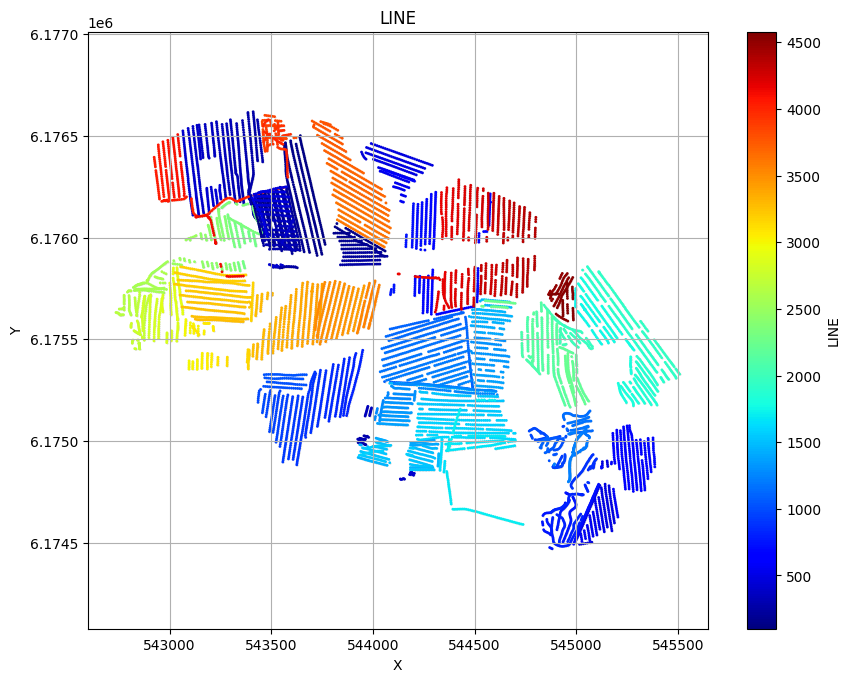

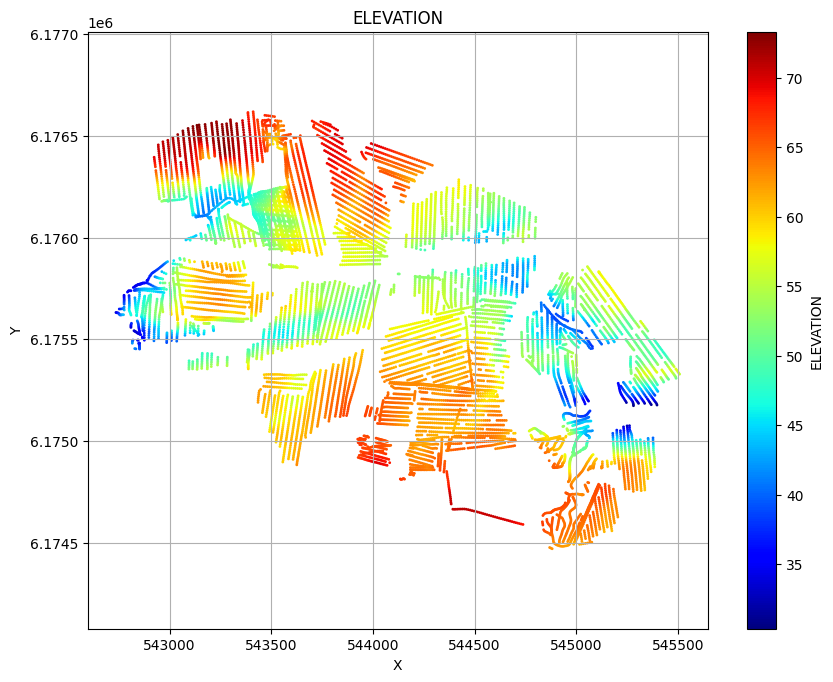

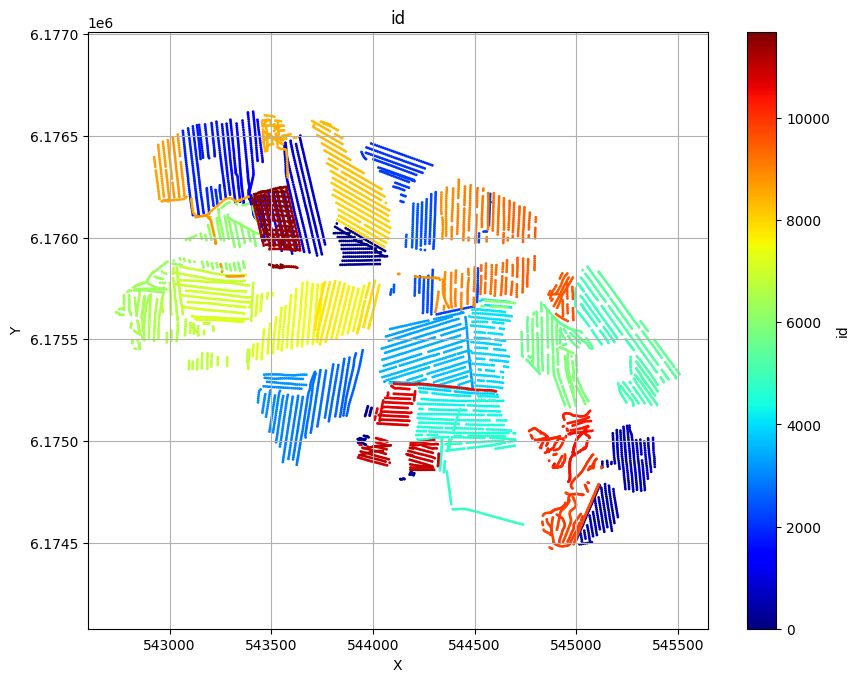

In [4]:
# The commented line below would plot LINE, ELEVATION and data id as three scatter plots:
# ig.plot_geometry(f_data_h5)
# Each plot can be generated separately by specifying the 'pl' argument:
ig.plot_geometry(f_data_h5, pl='LINE')
ig.plot_geometry(f_data_h5, pl='ELEVATION')
ig.plot_geometry(f_data_h5, pl='id')

plot_data: Found data set D1
plot_data: Using data set D1


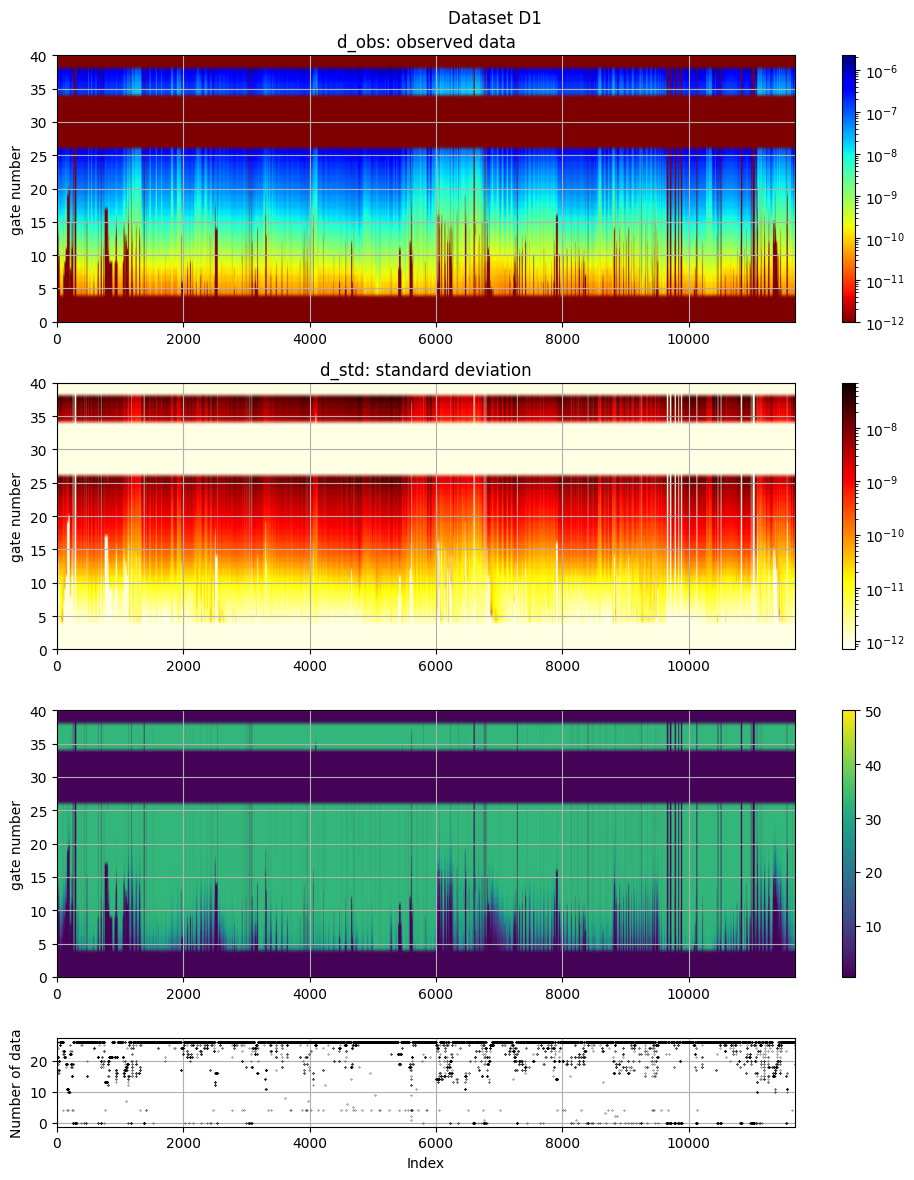

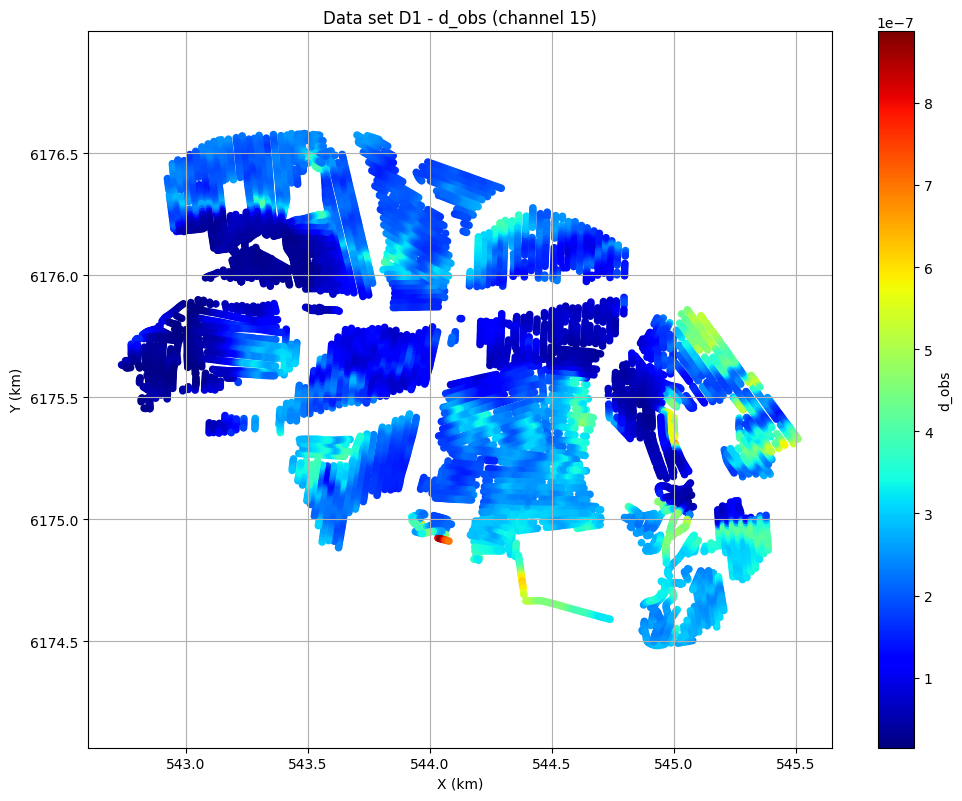

In [5]:
# The electromagnetic data (d_obs and d_std) can be plotted using ig.plot_data:
ig.plot_data(f_data_h5, hardcopy=hardcopy)
# Plot data channel 15 in an XY grid
ig.plot_data_xy(f_data_h5, data_channel=15, cmap='jet');

## 1. Set up the prior model ($\rho(\mathbf{m},\mathbf{d})$)

In this example, a simple layered prior model will be considered.
The prior represents our initial beliefs about subsurface resistivity structure.

### 1a. Generate prior model parameters
First, we generate a sample of the prior model parameters, $\rho(\mathbf{m})$.

As an example, we choose a simple layered Earth model. 
The number of layers follows a chi-squared distribution with 4 degrees of freedom, 
and the resistivity in each layer is log-uniformly distributed between [1,3000] Ωm.

This creates N realizations of 3 types of model parameters: 

    PRIOR:/M1: 1D resistivity values in 1m thick layers down to 90m depth
    PRIOR:/M2: 1D resistivity values in discrete parameter sets where the first 
               Nlayer parameters are resistivities, and the last Nlayer-1 
               parameters are depths to the base of each layer
    PRIOR:/M3: The number of layers in each model realization


In [6]:
# Select how many prior model realizations (N) should be generated
N=2000000
N=10000
f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='chi2', NLAY_deg=4, RHO_min=1, RHO_max=3000, f_prior_h5='PRIOR.h5')
print('%s is used to hold prior realizations' % (f_prior_h5))




prior_layered:   0%|                                                                        | 0/10000 [00:00<?, ?it/s]

PRIOR.h5 is used to hold prior realizations


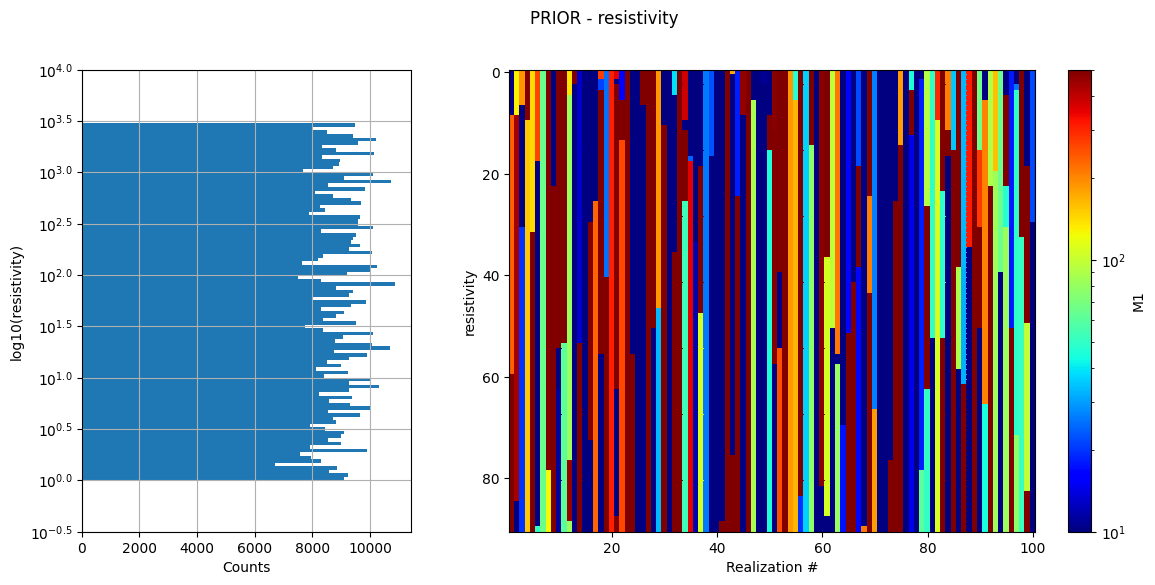

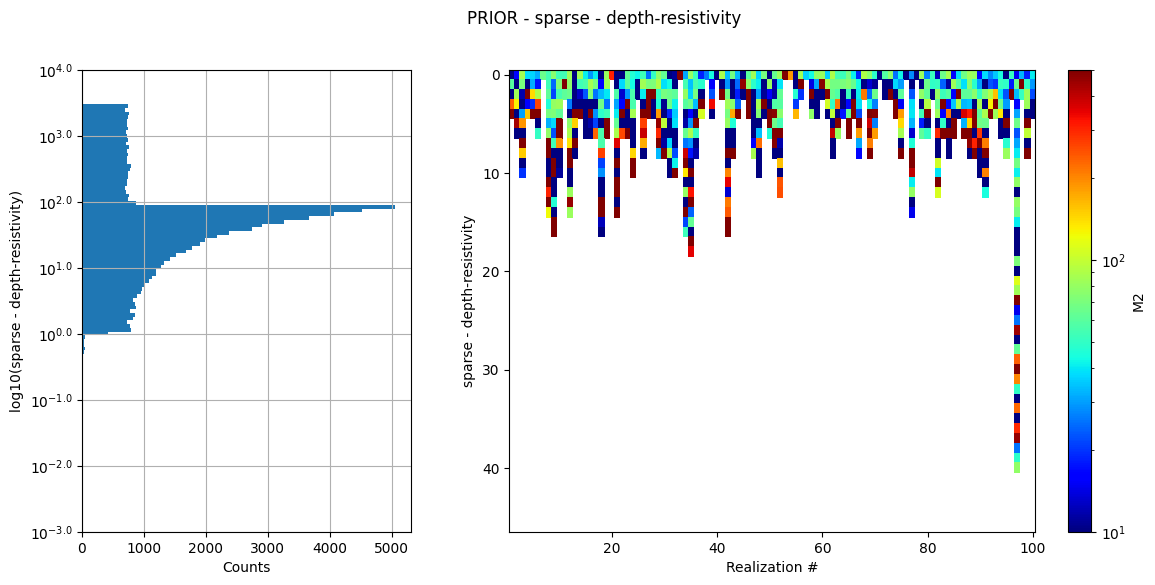

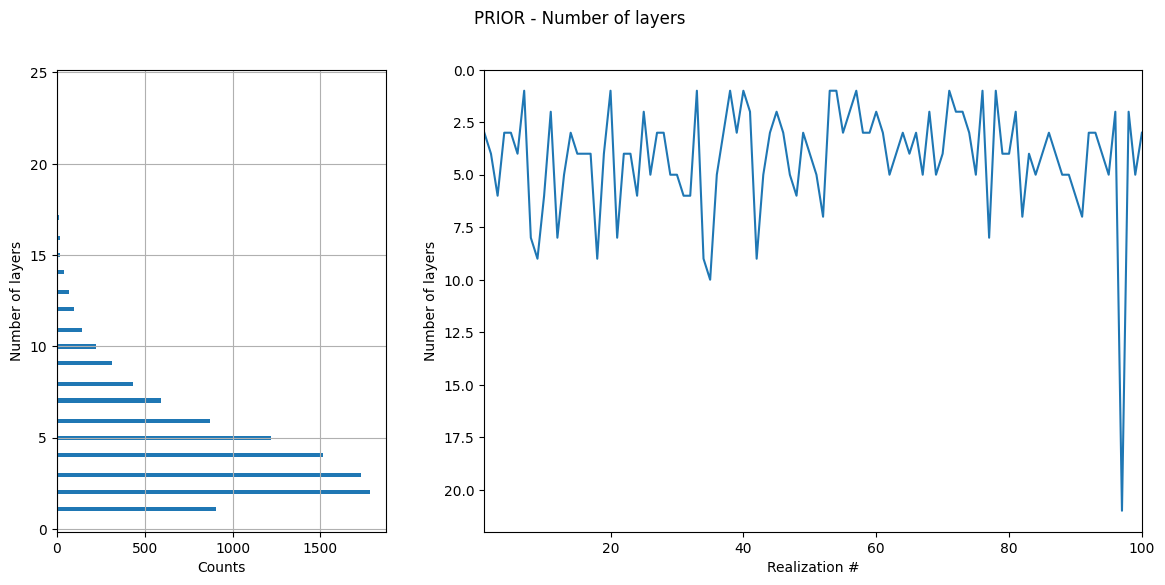

In [7]:
# Plot summary statistics of the prior model for quality control of the prior choice
ig.plot_prior_stats(f_prior_h5, hardcopy=hardcopy)

### 1b. Generate corresponding prior data
Next, we generate a corresponding sample of $\rho(\mathbf{d})$ (prior data distribution).

The prior data, corresponding to the prior model parameters, are computed using 
the GA-AEM electromagnetic forward modeling code and the GEX system configuration file.


In [8]:
# Option 1: Update the existing PRIOR.h5 file with forward-modeled data
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, doMakePriorCopy=True)
#f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, doMakePriorCopy=False, parallel=parallel)
# f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, parallel=parallel)

print('Updated %s to hold prior data (forward-modeled responses)' % (f_prior_data_h5))

Using file_basename=TX07_20231016_2x4_RC20-33
prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/312 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                              | 0/313 [00:00<?, ?it/s]

gatdaem1d:  15%|██████████▏                                                          | 46/312 [00:01<00:05, 45.83it/s]

gatdaem1d:  17%|███████████▉                                                         | 54/313 [00:01<00:04, 53.59it/s]

gatdaem1d:  14%|█████████▍                                                           | 43/313 [00:01<00:06, 42.69it/s]

gatdaem1d:  11%|███████▎                                                             | 33/312 [00:01<00:08, 32.84it/s]

gatdaem1d:  11%|███████▋                                                             | 35/312 [00:01<00:07, 34.80it/s]

gatdaem1d:  15%|██████████▌                                                          | 48/313 [00:01<00:05, 47.53it/s]

gatdaem1d:  14%|█████████▉                                                           | 45/312 [00:01<00:05, 44.60it/s]

gatdaem1d:  11%|███████▎                                                             | 33/312 [00:01<00:08, 32.94it/s]

gatdaem1d:   9%|██████▏                                                              | 28/312 [00:01<00:10, 27.60it/s]

gatdaem1d:   8%|█████▊                                                               | 26/312 [00:01<00:11, 25.93it/s]

gatdaem1d:  14%|█████████▌                                                           | 43/312 [00:01<00:06, 42.56it/s]

gatdaem1d:  11%|███████▌                                                             | 34/312 [00:01<00:08, 33.77it/s]

gatdaem1d:  14%|█████████▉                                                           | 45/312 [00:01<00:06, 44.20it/s]

gatdaem1d:  11%|███████▎                                                             | 33/312 [00:01<00:08, 32.72it/s]

gatdaem1d:   9%|██████▍                                                              | 29/312 [00:01<00:09, 28.54it/s]

gatdaem1d:  11%|███████▎                                                             | 33/313 [00:01<00:08, 32.46it/s]

gatdaem1d:  11%|███████▎                                                             | 33/313 [00:01<00:08, 32.26it/s]

gatdaem1d:  11%|███████▌                                                             | 34/312 [00:01<00:08, 32.96it/s]

gatdaem1d:  14%|█████████▋                                                           | 44/313 [00:01<00:06, 43.31it/s]

gatdaem1d:  10%|██████▊                                                              | 31/313 [00:01<00:09, 30.57it/s]

gatdaem1d:  14%|█████████▋                                                           | 44/313 [00:01<00:06, 43.72it/s]

gatdaem1d:  10%|██████▌                                                              | 30/313 [00:01<00:09, 29.11it/s]

gatdaem1d:  13%|█████████▎                                                           | 42/313 [00:01<00:06, 41.28it/s]

gatdaem1d:  14%|█████████▉                                                           | 45/312 [00:01<00:06, 44.13it/s]

gatdaem1d:  14%|█████████▉                                                           | 45/312 [00:01<00:06, 43.74it/s]

gatdaem1d:  10%|██████▌                                                              | 30/313 [00:01<00:09, 29.56it/s]

gatdaem1d:  14%|█████████▋                                                           | 44/313 [00:01<00:06, 43.87it/s]

gatdaem1d:  14%|█████████▋                                                           | 44/313 [00:01<00:06, 43.10it/s]

gatdaem1d:  11%|███████▎                                                             | 33/313 [00:01<00:08, 32.29it/s]

gatdaem1d:   7%|████▊                                                                | 22/313 [00:01<00:13, 21.53it/s]

gatdaem1d:   9%|██████▍                                                              | 29/313 [00:01<00:09, 28.52it/s]

gatdaem1d:  11%|███████▎                                                             | 33/312 [00:01<00:08, 32.04it/s]

gatdaem1d:  21%|██████████████▌                                                      | 66/312 [00:02<00:07, 32.83it/s]

gatdaem1d:  27%|██████████████████▉                                                  | 86/313 [00:02<00:05, 42.29it/s]

gatdaem1d:  29%|████████████████████▎                                                | 92/312 [00:02<00:04, 44.32it/s]

gatdaem1d:  19%|█████████████▎                                                       | 60/312 [00:02<00:08, 30.14it/s]

gatdaem1d:  25%|█████████████████                                                    | 77/312 [00:02<00:06, 39.01it/s]

gatdaem1d:  21%|██████████████▊                                                      | 67/312 [00:02<00:07, 34.62it/s]

gatdaem1d:  29%|███████████████████▉                                                 | 90/312 [00:02<00:05, 43.65it/s]

gatdaem1d:  27%|██████████████████▎                                                  | 83/312 [00:02<00:05, 42.58it/s]

gatdaem1d:  22%|███████████████▍                                                     | 70/312 [00:02<00:07, 33.44it/s]

gatdaem1d:  25%|█████████████████▏                                                   | 78/313 [00:02<00:05, 39.41it/s]

gatdaem1d:  20%|█████████████▉                                                       | 63/313 [00:02<00:08, 31.11it/s]

gatdaem1d:  20%|██████████████                                                       | 64/313 [00:02<00:07, 31.51it/s]

gatdaem1d:  20%|██████████████                                                       | 64/313 [00:02<00:07, 33.42it/s]

gatdaem1d:  28%|███████████████████                                                  | 86/312 [00:02<00:05, 41.59it/s]

gatdaem1d:  24%|████████████████▌                                                    | 75/313 [00:02<00:06, 37.59it/s]

gatdaem1d:  21%|██████████████▌                                                      | 66/312 [00:02<00:07, 31.83it/s]

gatdaem1d:  20%|██████████████                                                       | 64/313 [00:02<00:07, 31.68it/s]

gatdaem1d:  21%|██████████████▌                                                      | 66/313 [00:02<00:07, 31.49it/s]

gatdaem1d:  28%|███████████████████▍                                                 | 88/313 [00:02<00:05, 42.04it/s]

gatdaem1d:  28%|███████████████████▍                                                 | 88/313 [00:02<00:05, 42.34it/s]

gatdaem1d:  19%|████████████▊                                                        | 58/312 [00:02<00:09, 27.28it/s]

gatdaem1d:  29%|███████████████████▉                                                 | 90/312 [00:02<00:05, 42.70it/s]

gatdaem1d:  24%|████████████████▎                                                    | 74/313 [00:02<00:06, 38.06it/s]

gatdaem1d:  21%|██████████████▊                                                      | 67/312 [00:02<00:08, 30.02it/s]

gatdaem1d:  35%|███████████████████████▍                                            | 108/313 [00:02<00:04, 46.97it/s]

gatdaem1d:  21%|██████████████▌                                                      | 66/312 [00:02<00:08, 29.74it/s]

gatdaem1d:  28%|███████████████████▍                                                 | 88/313 [00:02<00:06, 36.90it/s]

gatdaem1d:  27%|██████████████████▌                                                  | 84/313 [00:02<00:06, 34.82it/s]

gatdaem1d:  28%|███████████████████▍                                                 | 88/313 [00:02<00:06, 36.29it/s]

gatdaem1d:  29%|███████████████████▉                                                 | 90/312 [00:02<00:06, 36.30it/s]

gatdaem1d:  31%|█████████████████████▏                                               | 96/313 [00:02<00:06, 35.75it/s]

gatdaem1d:  29%|███████████████████▋                                                 | 89/312 [00:02<00:06, 32.33it/s]

gatdaem1d:  31%|█████████████████████▍                                               | 97/312 [00:03<00:06, 33.14it/s]

gatdaem1d:  41%|████████████████████████████                                        | 129/313 [00:03<00:04, 42.32it/s]

gatdaem1d:  32%|█████████████████████▊                                              | 100/312 [00:03<00:06, 32.82it/s]

gatdaem1d:  38%|█████████████████████████▉                                          | 119/312 [00:03<00:04, 40.05it/s]

gatdaem1d:  31%|█████████████████████▏                                               | 96/313 [00:03<00:06, 31.94it/s]

gatdaem1d:  44%|█████████████████████████████▊                                      | 137/312 [00:03<00:04, 43.33it/s]

gatdaem1d:  41%|███████████████████████████▉                                        | 128/312 [00:03<00:04, 41.70it/s]

gatdaem1d:  33%|██████████████████████▋                                             | 104/312 [00:03<00:06, 33.28it/s]

gatdaem1d:  37%|█████████████████████████▏                                          | 116/313 [00:03<00:05, 38.99it/s]

gatdaem1d:  34%|██████████████████████▊                                             | 105/313 [00:03<00:05, 36.68it/s]

gatdaem1d:  35%|███████████████████████▍                                            | 108/313 [00:03<00:05, 36.86it/s]

gatdaem1d:  33%|██████████████████████▏                                             | 102/312 [00:03<00:06, 33.76it/s]

gatdaem1d:  31%|█████████████████████▋                                               | 98/312 [00:03<00:06, 31.75it/s]

gatdaem1d:  34%|███████████████████████▏                                            | 107/313 [00:03<00:05, 36.39it/s]

gatdaem1d:  35%|███████████████████████▉                                            | 110/313 [00:03<00:05, 36.85it/s]

gatdaem1d:  29%|████████████████████▏                                                | 91/312 [00:03<00:07, 29.69it/s]

gatdaem1d:  42%|████████████████████████████▋                                       | 132/313 [00:03<00:04, 42.40it/s]

gatdaem1d:  37%|████████████████████████▉                                           | 115/313 [00:03<00:05, 39.27it/s]

gatdaem1d:  43%|████████████████████████████▉                                       | 133/312 [00:03<00:04, 42.05it/s]

gatdaem1d:  40%|███████████████████████████▍                                        | 126/312 [00:03<00:04, 39.71it/s]

gatdaem1d:  35%|███████████████████████▉                                            | 110/312 [00:03<00:05, 35.41it/s]

gatdaem1d:  38%|█████████████████████████▋                                          | 118/313 [00:03<00:05, 35.61it/s]

gatdaem1d:  32%|█████████████████████▉                                               | 99/312 [00:03<00:06, 30.89it/s]

gatdaem1d:  50%|█████████████████████████████████▉                                  | 156/313 [00:03<00:03, 44.93it/s]

gatdaem1d:  42%|████████████████████████████▊                                       | 132/312 [00:03<00:04, 38.33it/s]

gatdaem1d:  43%|█████████████████████████████▏                                      | 134/312 [00:03<00:04, 36.91it/s]

gatdaem1d:  42%|████████████████████████████▍                                       | 131/313 [00:03<00:04, 36.87it/s]

gatdaem1d:  38%|██████████████████████████                                          | 120/313 [00:03<00:05, 34.01it/s]

gatdaem1d:  40%|███████████████████████████▎                                        | 126/313 [00:03<00:05, 34.87it/s]

gatdaem1d:  43%|█████████████████████████████                                       | 134/313 [00:03<00:04, 36.08it/s]

gatdaem1d:  40%|███████████████████████████▎                                        | 126/313 [00:03<00:05, 34.23it/s]

gatdaem1d:  40%|███████████████████████████                                         | 124/312 [00:03<00:05, 32.06it/s]

gatdaem1d:  43%|████████████████████████████▉                                       | 133/312 [00:04<00:05, 32.84it/s]

gatdaem1d:  55%|█████████████████████████████████████▎                              | 172/313 [00:04<00:03, 42.29it/s]

gatdaem1d:  52%|███████████████████████████████████▌                                | 163/312 [00:04<00:03, 41.25it/s]

gatdaem1d:  41%|███████████████████████████▊                                        | 128/313 [00:04<00:05, 31.87it/s]

gatdaem1d:  54%|█████████████████████████████████████                               | 170/312 [00:04<00:03, 41.75it/s]

gatdaem1d:  48%|████████████████████████████████▌                                   | 150/313 [00:04<00:04, 38.73it/s]

gatdaem1d:  58%|███████████████████████████████████████▍                            | 181/312 [00:04<00:03, 43.11it/s]

gatdaem1d:  47%|████████████████████████████████▎                                   | 148/312 [00:04<00:04, 37.13it/s]

gatdaem1d:  42%|████████████████████████████▌                                       | 131/312 [00:04<00:05, 32.39it/s]

gatdaem1d:  47%|████████████████████████████████▏                                   | 148/313 [00:04<00:04, 38.77it/s]

gatdaem1d:  42%|████████████████████████████▊                                       | 132/312 [00:04<00:05, 32.41it/s]

gatdaem1d:  44%|█████████████████████████████▋                                      | 136/312 [00:04<00:05, 33.47it/s]

gatdaem1d:  48%|████████████████████████████████▌                                   | 150/313 [00:04<00:04, 38.77it/s]

gatdaem1d:  49%|█████████████████████████████████                                   | 152/313 [00:04<00:04, 38.59it/s]

gatdaem1d:  43%|████████████████████████████▉                                       | 133/312 [00:04<00:05, 34.18it/s]

gatdaem1d:  50%|██████████████████████████████████                                  | 157/313 [00:04<00:03, 40.11it/s]

gatdaem1d:  56%|██████████████████████████████████████▎                             | 176/312 [00:04<00:03, 41.95it/s]

gatdaem1d:  50%|█████████████████████████████████▉                                  | 156/313 [00:04<00:04, 37.07it/s]

gatdaem1d:  49%|█████████████████████████████████▎                                  | 153/312 [00:04<00:04, 38.00it/s]

gatdaem1d:  42%|████████████████████████████▊                                       | 132/312 [00:04<00:05, 31.51it/s]

gatdaem1d:  53%|████████████████████████████████████▏                               | 166/312 [00:04<00:03, 36.71it/s]

gatdaem1d:  56%|██████████████████████████████████████▎                             | 176/312 [00:04<00:03, 38.53it/s]

gatdaem1d:  56%|██████████████████████████████████████                              | 175/313 [00:04<00:03, 37.95it/s]

gatdaem1d:  65%|███████████████████████████████████████████▉                        | 202/313 [00:04<00:02, 43.53it/s]

gatdaem1d:  50%|█████████████████████████████████▋                                  | 155/313 [00:04<00:04, 34.11it/s]

gatdaem1d:  52%|███████████████████████████████████▍                                | 163/313 [00:04<00:04, 37.17it/s]

gatdaem1d:  54%|████████████████████████████████████▋                               | 169/313 [00:04<00:04, 35.09it/s]

gatdaem1d:  52%|███████████████████████████████████▏                                | 162/313 [00:04<00:04, 33.72it/s]

gatdaem1d:  55%|█████████████████████████████████████▍                              | 172/312 [00:04<00:03, 35.84it/s]

gatdaem1d:  51%|██████████████████████████████████▉                                 | 161/313 [00:04<00:04, 33.48it/s]

gatdaem1d:  51%|██████████████████████████████████▍                                 | 158/312 [00:04<00:04, 32.52it/s]

gatdaem1d:  55%|█████████████████████████████████████▎                              | 172/313 [00:04<00:04, 34.11it/s]

gatdaem1d:  53%|████████████████████████████████████▏                               | 166/312 [00:05<00:04, 32.35it/s]

gatdaem1d:  66%|████████████████████████████████████████████▉                       | 206/312 [00:05<00:02, 41.55it/s]

gatdaem1d:  51%|██████████████████████████████████▉                                 | 161/313 [00:05<00:04, 32.22it/s]

gatdaem1d:  56%|█████████████████████████████████████▉                              | 174/312 [00:05<00:03, 36.10it/s]

gatdaem1d:  60%|████████████████████████████████████████▌                           | 186/312 [00:05<00:03, 37.37it/s]

gatdaem1d:  62%|██████████████████████████████████████████▏                         | 194/313 [00:05<00:02, 40.40it/s]

gatdaem1d:  72%|█████████████████████████████████████████████████                   | 225/312 [00:05<00:02, 42.95it/s]

gatdaem1d:  61%|█████████████████████████████████████████▋                          | 192/313 [00:05<00:03, 39.84it/s]

gatdaem1d:  57%|██████████████████████████████████████▊                             | 178/312 [00:05<00:03, 36.29it/s]

gatdaem1d:  56%|██████████████████████████████████████▏                             | 175/312 [00:05<00:03, 35.83it/s]

gatdaem1d:  62%|██████████████████████████████████████████▎                         | 195/313 [00:05<00:02, 39.96it/s]

gatdaem1d:  54%|████████████████████████████████████▌                               | 168/312 [00:05<00:04, 34.18it/s]

gatdaem1d:  64%|███████████████████████████████████████████▍                        | 200/313 [00:05<00:02, 40.86it/s]

gatdaem1d:  70%|███████████████████████████████████████████████▌                    | 218/312 [00:05<00:02, 41.75it/s]

gatdaem1d:  63%|██████████████████████████████████████████▋                         | 196/312 [00:05<00:02, 39.67it/s]

gatdaem1d:  60%|████████████████████████████████████████▋                           | 187/313 [00:05<00:03, 36.16it/s]

gatdaem1d:  69%|██████████████████████████████████████████████▋                     | 215/313 [00:05<00:02, 38.47it/s]

gatdaem1d:  68%|██████████████████████████████████████████████▏                     | 212/312 [00:05<00:02, 38.01it/s]

gatdaem1d:  53%|████████████████████████████████████▏                               | 166/312 [00:05<00:04, 32.11it/s]

gatdaem1d:  62%|██████████████████████████████████████████▏                         | 194/313 [00:05<00:03, 34.82it/s]

gatdaem1d:  70%|███████████████████████████████████████████████▌                    | 218/312 [00:05<00:02, 39.63it/s]

gatdaem1d:  69%|███████████████████████████████████████████████▏                    | 217/313 [00:05<00:02, 39.22it/s]

gatdaem1d:  64%|███████████████████████████████████████████▏                        | 199/313 [00:05<00:03, 37.18it/s]

gatdaem1d:  64%|███████████████████████████████████████████▋                        | 201/313 [00:05<00:03, 36.41it/s]

gatdaem1d:  65%|████████████████████████████████████████████▍                       | 204/312 [00:05<00:03, 34.93it/s]

gatdaem1d:  69%|██████████████████████████████████████████████▊                     | 215/312 [00:05<00:02, 37.96it/s]

gatdaem1d:  63%|███████████████████████████████████████████                         | 198/313 [00:05<00:03, 34.46it/s]

gatdaem1d:  63%|██████████████████████████████████████████▌                         | 196/313 [00:05<00:03, 32.95it/s]

gatdaem1d:  65%|████████████████████████████████████████████▌                       | 205/313 [00:05<00:03, 34.15it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████▍              | 246/313 [00:05<00:01, 39.24it/s]

gatdaem1d:  62%|█████████████████████████████████████████▊                          | 192/312 [00:05<00:03, 31.88it/s]

gatdaem1d:  66%|████████████████████████████████████████████▉                       | 207/313 [00:05<00:03, 32.84it/s]

gatdaem1d:  62%|██████████████████████████████████████████▎                         | 195/313 [00:06<00:03, 32.71it/s]

gatdaem1d:  64%|███████████████████████████████████████████▌                        | 200/312 [00:06<00:03, 32.65it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████▉                  | 229/312 [00:06<00:02, 39.21it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████▍                | 237/313 [00:06<00:01, 41.13it/s]

gatdaem1d:  70%|███████████████████████████████████████████████▎                    | 217/312 [00:06<00:02, 38.11it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████▊                 | 234/313 [00:06<00:01, 40.39it/s]

gatdaem1d:  70%|███████████████████████████████████████████████▌                    | 218/312 [00:06<00:02, 38.12it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████▍         | 268/312 [00:06<00:01, 42.34it/s]

gatdaem1d:  65%|████████████████████████████████████████████▏                       | 203/312 [00:06<00:03, 33.97it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████           | 262/312 [00:06<00:01, 42.30it/s]

gatdaem1d:  69%|██████████████████████████████████████████████▊                     | 215/312 [00:06<00:02, 35.27it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████▎                | 236/313 [00:06<00:01, 38.51it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████▎               | 241/313 [00:06<00:01, 39.38it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████▏                 | 231/313 [00:06<00:02, 38.50it/s]

gatdaem1d:  81%|███████████████████████████████████████████████████████▎            | 254/312 [00:06<00:01, 39.27it/s]

gatdaem1d:  79%|██████████████████████████████████████████████████████              | 248/312 [00:06<00:01, 37.66it/s]

gatdaem1d:  67%|█████████████████████████████████████████████▊                      | 210/312 [00:06<00:02, 35.75it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████▊                 | 234/313 [00:06<00:02, 36.35it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████▎           | 259/313 [00:06<00:01, 40.05it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████▍           | 259/312 [00:06<00:01, 39.86it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████▍                | 236/312 [00:06<00:02, 36.29it/s]

gatdaem1d:  81%|███████████████████████████████████████████████████████▏            | 254/313 [00:06<00:01, 36.16it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████▍                | 237/313 [00:06<00:02, 36.42it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████▌               | 242/313 [00:06<00:01, 37.68it/s]

gatdaem1d:  79%|█████████████████████████████████████████████████████▌              | 246/312 [00:06<00:01, 36.96it/s]

gatdaem1d:  82%|████████████████████████████████████████████████████████            | 257/312 [00:06<00:01, 38.91it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████▉                  | 230/313 [00:06<00:02, 32.44it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████▌                 | 233/313 [00:06<00:02, 32.91it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████▏               | 240/313 [00:06<00:02, 32.90it/s]

gatdaem1d:  72%|█████████████████████████████████████████████████                   | 225/312 [00:06<00:02, 32.03it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████▎               | 241/313 [00:07<00:02, 32.19it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:07<00:00, 36.41it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████                | 239/312 [00:07<00:02, 34.55it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████▊       | 280/313 [00:07<00:00, 41.57it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████▏           | 258/312 [00:07<00:01, 38.85it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████▌                  | 228/313 [00:07<00:02, 32.21it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████▋           | 260/312 [00:07<00:01, 39.27it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▉        | 276/313 [00:07<00:00, 40.58it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████▊| 311/312 [00:07<00:00, 41.70it/s]

gatdaem1d:  82%|████████████████████████████████████████████████████████            | 257/312 [00:07<00:01, 37.16it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████▊                | 238/312 [00:07<00:02, 33.73it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████▋         | 269/312 [00:07<00:01, 36.61it/s]

gatdaem1d:  87%|███████████████████████████████████████████████████████████▎        | 273/313 [00:07<00:01, 39.35it/s]

gatdaem1d:  95%|████████████████████████████████████████████████████████████████▎   | 295/312 [00:07<00:00, 39.59it/s]

gatdaem1d:  81%|███████████████████████████████████████████████████████▏            | 253/312 [00:07<00:01, 37.88it/s]

gatdaem1d:  89%|████████████████████████████████████████████████████████████▍       | 278/313 [00:07<00:00, 38.57it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████▏  | 300/313 [00:07<00:00, 40.29it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████▌  | 301/312 [00:07<00:00, 40.38it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▋        | 275/313 [00:07<00:01, 36.34it/s]

gatdaem1d:  90%|█████████████████████████████████████████████████████████████       | 281/313 [00:07<00:00, 37.11it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████▍ | 305/312 [00:07<00:00, 38.52it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████▌     | 287/312 [00:07<00:00, 35.94it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:07<00:00, 39.58it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████▏    | 290/312 [00:07<00:00, 39.03it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████▏    | 291/313 [00:07<00:00, 35.11it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▌        | 273/312 [00:07<00:01, 35.10it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:07<00:01, 34.99it/s]

gatdaem1d:  96%|█████████████████████████████████████████████████████████████████▍  | 300/312 [00:07<00:00, 39.89it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████▏          | 263/313 [00:07<00:01, 32.31it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████          | 267/313 [00:07<00:01, 32.91it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████▍           | 259/312 [00:07<00:01, 32.60it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:07<00:01, 32.36it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▋        | 275/313 [00:08<00:01, 32.56it/s]

gatdaem1d:  97%|██████████████████████████████████████████████████████████████████▎ | 304/312 [00:08<00:00, 40.96it/s]

gatdaem1d:  86%|██████████████████████████████████████████████████████████▍         | 269/313 [00:08<00:01, 34.87it/s]

gatdaem1d:  88%|███████████████████████████████████████████████████████████▋        | 274/312 [00:08<00:01, 34.11it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████▍ | 305/312 [00:08<00:00, 40.92it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████▍ | 305/312 [00:08<00:00, 40.35it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████▋      | 283/312 [00:08<00:00, 37.20it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████▏| 308/312 [00:08<00:00, 37.22it/s]

gatdaem1d:  94%|███████████████████████████████████████████████████████████████▊    | 293/312 [00:08<00:00, 38.38it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:08<00:00, 36.47it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:08<00:00, 36.42it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████▏| 308/312 [00:08<00:00, 37.45it/s]

prior_data_gaaem: Time=  9.4s/10000 soundings.  0.9ms/sounding, 1063.5it/s
Updated PRIOR_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5 to hold prior data (forward-modeled responses)


In [9]:
D = ig.load_prior_data(f_prior_data_h5)[0][0]

Loading prior data from PRIOR_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5. Using prior data ids: []
  - /D1:  N,nd = 10000/40


It is useful to compare the prior data to the observed data before inversion. 
If there is little to no overlap between observed and prior data, the inversion 
is unlikely to succeed, indicating inconsistency between the prior model and observations.
In the figure below, you can see that the observed data (red) falls clearly within 
the range of the prior data distribution.

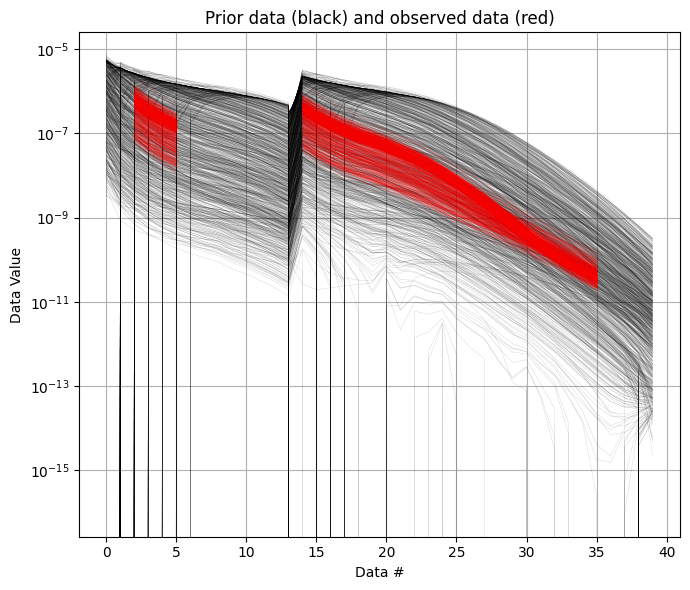

True

In [10]:
ig.plot_data_prior(f_prior_data_h5,f_data_h5,nr=1000,hardcopy=hardcopy)

## 2. Sample the posterior distribution $\sigma(\mathbf{m})$

The posterior distribution is sampled using the extended rejection sampler.

In [11]:
# Rejection sampling of the posterior can be done with default settings using:
#f_post_h5 = ig.integrate_rejection(f_prior_h5, f_data_h5)

# However, you can control several important options.
# You can choose to use only a subset of the prior data. Decreasing the sample 
# size makes the inversion faster but increasingly approximate.
N_use = N   # Number of prior samples to use (use all available)
T_base = 1  # Base annealing temperature for rejection sampling
autoT = 1   # Automatically estimate optimal annealing temperature
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, 
                                   f_data_h5, 
                                   f_post_h5 = 'POST.h5', 
                                   N_use = N_use, 
                                   autoT = autoT,
                                   T_base = T_base,                            
                                   showInfo=1, 
                                   parallel=parallel)

File POST.h5 allready exists
Overwriting...
Loading data from DAUGAARD_AVG.h5. Using data types: [1]
  - D1: id_use=1,    gaussian, Using 11693/40 data
Loading prior data from PRIOR_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5. Using prior data ids: [1]
  - /D1:  N,nd = 10000/40
<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5, f_data_h5=DAUGAARD_AVG.h5
f_post_h5=POST.h5


Rejection Sampling:   0%|                                                                    | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                    | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                    | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                    | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                    | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                    | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   4%|██▏                                                       | 54/1462 [00:00<00:02, 533.53it/s]

Rejection Sampling:   0%|                                                                    | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   3%|█▉                                                        | 49/1462 [00:00<00:02, 488.08it/s]

Rejection Sampling:   3%|█▋                                                        | 43/1462 [00:00<00:03, 421.83it/s]

Rejection Sampling:   0%|                                                                    | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   3%|█▋                                                        | 41/1462 [00:00<00:03, 403.35it/s]

Rejection Sampling:   2%|█▍                                                        | 36/1462 [00:00<00:03, 357.90it/s]

Rejection Sampling:   2%|█▍                                                        | 35/1461 [00:00<00:04, 346.98it/s]

Rejection Sampling:   2%|█▎                                                        | 34/1461 [00:00<00:04, 336.74it/s]

Rejection Sampling:   2%|█                                                         | 28/1461 [00:00<00:05, 273.84it/s]

Rejection Sampling:   6%|███▍                                                      | 86/1462 [00:00<00:03, 356.11it/s]

Rejection Sampling:   7%|████▏                                                    | 108/1462 [00:00<00:03, 386.36it/s]

Rejection Sampling:   6%|███▎                                                      | 82/1462 [00:00<00:03, 347.51it/s]

Rejection Sampling:   7%|███▉                                                      | 98/1462 [00:00<00:03, 359.63it/s]

Rejection Sampling:   5%|██▊                                                       | 72/1462 [00:00<00:04, 328.84it/s]

Rejection Sampling:   5%|██▊                                                       | 70/1461 [00:00<00:04, 323.83it/s]

Rejection Sampling:   5%|██▋                                                       | 68/1461 [00:00<00:04, 320.28it/s]

Rejection Sampling:   4%|██▎                                                       | 59/1461 [00:00<00:04, 294.18it/s]

Rejection Sampling:   8%|████▊                                                    | 123/1462 [00:00<00:03, 335.17it/s]

Rejection Sampling:   8%|████▌                                                    | 118/1462 [00:00<00:04, 330.21it/s]

Rejection Sampling:   7%|████▏                                                    | 106/1462 [00:00<00:04, 318.92it/s]

Rejection Sampling:   9%|█████▎                                                   | 136/1462 [00:00<00:03, 335.20it/s]

Rejection Sampling:  10%|█████▊                                                   | 150/1462 [00:00<00:03, 353.07it/s]

Rejection Sampling:   7%|████                                                     | 103/1461 [00:00<00:04, 317.09it/s]

Rejection Sampling:   7%|███▉                                                     | 101/1461 [00:00<00:04, 314.98it/s]

Rejection Sampling:   6%|███▌                                                      | 90/1461 [00:00<00:04, 298.01it/s]

Rejection Sampling:  11%|██████                                                   | 157/1462 [00:00<00:04, 325.60it/s]

Rejection Sampling:  10%|█████▉                                                   | 152/1462 [00:00<00:04, 322.34it/s]

Rejection Sampling:   9%|█████▍                                                   | 138/1462 [00:00<00:04, 314.83it/s]

Rejection Sampling:   9%|█████▎                                                   | 135/1461 [00:00<00:04, 314.37it/s]

Rejection Sampling:  12%|██████▋                                                  | 171/1462 [00:00<00:03, 326.86it/s]

Rejection Sampling:   9%|█████▏                                                   | 133/1461 [00:00<00:04, 314.60it/s]

Rejection Sampling:  13%|███████▎                                                 | 187/1462 [00:00<00:04, 314.56it/s]

Rejection Sampling:   8%|████▊                                                    | 122/1461 [00:00<00:04, 305.43it/s]

Rejection Sampling:  13%|███████▍                                                 | 191/1462 [00:00<00:03, 329.07it/s]

Rejection Sampling:  12%|██████▋                                                  | 172/1462 [00:00<00:03, 322.63it/s]

Rejection Sampling:  13%|███████▎                                                 | 186/1462 [00:00<00:03, 327.32it/s]

Rejection Sampling:  12%|██████▌                                                  | 169/1461 [00:00<00:04, 321.02it/s]

Rejection Sampling:  14%|███████▉                                                 | 205/1462 [00:00<00:03, 322.59it/s]

Rejection Sampling:  11%|██████▍                                                  | 166/1461 [00:00<00:04, 319.12it/s]

Rejection Sampling:  11%|██████                                                   | 154/1461 [00:00<00:04, 308.62it/s]

Rejection Sampling:  15%|████████▌                                                | 220/1462 [00:00<00:04, 303.70it/s]

Rejection Sampling:  15%|████████▊                                                | 225/1462 [00:00<00:03, 322.82it/s]

Rejection Sampling:  14%|███████▉                                                 | 205/1462 [00:00<00:03, 320.62it/s]

Rejection Sampling:  15%|████████▌                                                | 219/1462 [00:00<00:03, 323.82it/s]

Rejection Sampling:  14%|███████▉                                                 | 202/1461 [00:00<00:03, 321.54it/s]

Rejection Sampling:  16%|█████████▎                                               | 238/1462 [00:00<00:03, 323.27it/s]

Rejection Sampling:  14%|███████▊                                                 | 199/1461 [00:00<00:03, 321.54it/s]

Rejection Sampling:  13%|███████▎                                                 | 187/1461 [00:00<00:04, 312.64it/s]

Rejection Sampling:  17%|█████████▊                                               | 251/1462 [00:00<00:04, 293.25it/s]

Rejection Sampling:  18%|██████████                                               | 258/1462 [00:00<00:03, 319.64it/s]

Rejection Sampling:  17%|█████████▊                                               | 252/1462 [00:00<00:03, 318.09it/s]

Rejection Sampling:  16%|█████████▏                                               | 235/1461 [00:00<00:03, 319.08it/s]

Rejection Sampling:  16%|█████████▎                                               | 238/1462 [00:00<00:04, 302.53it/s]

Rejection Sampling:  19%|██████████▌                                              | 271/1462 [00:00<00:03, 320.07it/s]

Rejection Sampling:  16%|█████████                                                | 232/1461 [00:00<00:03, 318.46it/s]

Rejection Sampling:  15%|████████▌                                                | 219/1461 [00:00<00:03, 310.63it/s]

Rejection Sampling:  19%|██████████▉                                              | 282/1462 [00:00<00:03, 295.96it/s]

Rejection Sampling:  19%|███████████                                              | 284/1462 [00:00<00:03, 317.09it/s]

Rejection Sampling:  20%|███████████▎                                             | 291/1462 [00:00<00:03, 315.82it/s]

Rejection Sampling:  19%|██████████▌                                              | 271/1462 [00:00<00:03, 309.20it/s]

Rejection Sampling:  21%|███████████▊                                             | 304/1462 [00:00<00:03, 321.57it/s]

Rejection Sampling:  18%|██████████▍                                              | 267/1461 [00:00<00:03, 311.72it/s]

Rejection Sampling:  18%|██████████▎                                              | 264/1461 [00:00<00:03, 311.82it/s]

Rejection Sampling:  17%|█████████▊                                               | 251/1461 [00:00<00:03, 313.48it/s]

Rejection Sampling:  22%|████████████▎                                            | 316/1462 [00:00<00:03, 305.55it/s]

Rejection Sampling:  22%|████████████▎                                            | 316/1462 [00:00<00:03, 316.07it/s]

Rejection Sampling:  22%|████████████▌                                            | 323/1462 [00:00<00:03, 314.97it/s]

Rejection Sampling:  21%|███████████▊                                             | 304/1462 [00:00<00:03, 313.27it/s]

Rejection Sampling:  23%|█████████████▏                                           | 337/1462 [00:01<00:03, 322.23it/s]

Rejection Sampling:  20%|███████████▌                                             | 297/1461 [00:00<00:03, 315.63it/s]

Rejection Sampling:  19%|███████████                                              | 283/1461 [00:00<00:03, 314.09it/s]

Rejection Sampling:  20%|███████████▋                                             | 299/1461 [00:00<00:04, 274.07it/s]

Rejection Sampling:  24%|█████████████▌                                           | 349/1462 [00:01<00:03, 310.80it/s]

Rejection Sampling:  24%|█████████████▋                                           | 350/1462 [00:01<00:03, 320.10it/s]

Rejection Sampling:  24%|█████████████▉                                           | 356/1462 [00:01<00:03, 319.21it/s]

Rejection Sampling:  23%|█████████████                                            | 336/1462 [00:01<00:03, 313.85it/s]

Rejection Sampling:  25%|██████████████▍                                          | 370/1462 [00:01<00:03, 322.58it/s]

Rejection Sampling:  23%|████████████▊                                            | 330/1461 [00:01<00:03, 317.41it/s]

Rejection Sampling:  22%|████████████▎                                            | 315/1461 [00:01<00:03, 315.49it/s]

Rejection Sampling:  23%|████████████▊                                            | 330/1461 [00:01<00:03, 283.01it/s]

Rejection Sampling:  26%|██████████████▊                                          | 381/1462 [00:01<00:03, 311.21it/s]

Rejection Sampling:  27%|███████████████▏                                         | 388/1462 [00:01<00:03, 315.31it/s]

Rejection Sampling:  26%|██████████████▉                                          | 383/1462 [00:01<00:03, 316.02it/s]

Rejection Sampling:  25%|██████████████▎                                          | 368/1462 [00:01<00:03, 312.19it/s]

Rejection Sampling:  28%|███████████████▋                                         | 403/1462 [00:01<00:03, 318.93it/s]

Rejection Sampling:  25%|██████████████                                           | 362/1461 [00:01<00:03, 315.12it/s]

Rejection Sampling:  24%|█████████████▌                                           | 347/1461 [00:01<00:03, 313.76it/s]

Rejection Sampling:  25%|██████████████                                           | 361/1461 [00:01<00:03, 288.43it/s]

Rejection Sampling:  28%|████████████████                                         | 413/1462 [00:01<00:03, 311.11it/s]

Rejection Sampling:  29%|████████████████▎                                        | 420/1462 [00:01<00:03, 314.63it/s]

Rejection Sampling:  28%|████████████████▏                                        | 416/1462 [00:01<00:03, 317.46it/s]

Rejection Sampling:  27%|███████████████▋                                         | 401/1462 [00:01<00:03, 314.75it/s]

Rejection Sampling:  30%|████████████████▉                                        | 435/1462 [00:01<00:03, 318.90it/s]

Rejection Sampling:  27%|███████████████▍                                         | 395/1461 [00:01<00:03, 316.87it/s]

Rejection Sampling:  26%|██████████████▊                                          | 380/1461 [00:01<00:03, 316.19it/s]

Rejection Sampling:  27%|███████████████▎                                         | 391/1461 [00:01<00:03, 286.38it/s]

Rejection Sampling:  31%|█████████████████▍                                       | 446/1462 [00:01<00:03, 316.44it/s]

Rejection Sampling:  31%|█████████████████▌                                       | 450/1462 [00:01<00:03, 322.29it/s]

Rejection Sampling:  32%|██████████████████▎                                      | 469/1462 [00:01<00:03, 323.27it/s]

Rejection Sampling:  31%|█████████████████▌                                       | 452/1462 [00:01<00:03, 294.01it/s]

Rejection Sampling:  29%|████████████████▋                                        | 429/1461 [00:01<00:03, 321.64it/s]

Rejection Sampling:  30%|████████████████▉                                        | 433/1462 [00:01<00:03, 296.06it/s]

Rejection Sampling:  28%|████████████████▏                                        | 414/1461 [00:01<00:03, 320.48it/s]

Rejection Sampling:  29%|████████████████▌                                        | 424/1461 [00:01<00:03, 296.21it/s]

Rejection Sampling:  33%|██████████████████▋                                      | 479/1462 [00:01<00:03, 320.32it/s]

Rejection Sampling:  33%|██████████████████▊                                      | 483/1462 [00:01<00:03, 323.75it/s]

Rejection Sampling:  34%|███████████████████▌                                     | 502/1462 [00:01<00:02, 324.27it/s]

Rejection Sampling:  33%|██████████████████▉                                      | 485/1462 [00:01<00:03, 303.04it/s]

Rejection Sampling:  32%|██████████████████                                       | 462/1461 [00:01<00:03, 322.94it/s]

Rejection Sampling:  32%|██████████████████▏                                      | 466/1462 [00:01<00:03, 305.32it/s]

Rejection Sampling:  31%|█████████████████▍                                       | 447/1461 [00:01<00:03, 323.07it/s]

Rejection Sampling:  35%|███████████████████▉                                     | 512/1462 [00:01<00:02, 322.05it/s]

Rejection Sampling:  31%|█████████████████▋                                       | 454/1461 [00:01<00:03, 274.42it/s]

Rejection Sampling:  35%|████████████████████                                     | 516/1462 [00:01<00:02, 323.05it/s]

Rejection Sampling:  37%|████████████████████▊                                    | 535/1462 [00:01<00:02, 324.07it/s]

Rejection Sampling:  35%|████████████████████▏                                    | 518/1462 [00:01<00:03, 308.90it/s]

Rejection Sampling:  34%|███████████████████▎                                     | 495/1461 [00:01<00:02, 324.06it/s]

Rejection Sampling:  34%|███████████████████▍                                     | 499/1462 [00:01<00:03, 311.38it/s]

Rejection Sampling:  33%|██████████████████▋                                      | 480/1461 [00:01<00:03, 324.80it/s]

Rejection Sampling:  37%|█████████████████████▎                                   | 546/1462 [00:01<00:02, 325.18it/s]

Rejection Sampling:  38%|█████████████████████▍                                   | 550/1462 [00:01<00:02, 325.19it/s]

Rejection Sampling:  33%|██████████████████▊                                      | 482/1461 [00:01<00:03, 260.70it/s]

Rejection Sampling:  39%|██████████████████████▏                                  | 568/1462 [00:01<00:02, 325.65it/s]

Rejection Sampling:  38%|█████████████████████▍                                   | 551/1462 [00:01<00:02, 314.58it/s]

Rejection Sampling:  36%|████████████████████▌                                    | 528/1461 [00:01<00:02, 322.54it/s]

Rejection Sampling:  36%|████████████████████▋                                    | 532/1462 [00:01<00:02, 315.87it/s]

Rejection Sampling:  35%|████████████████████                                     | 513/1461 [00:01<00:02, 324.79it/s]

Rejection Sampling:  40%|██████████████████████▌                                  | 580/1462 [00:01<00:02, 328.17it/s]

Rejection Sampling:  40%|██████████████████████▊                                  | 585/1462 [00:01<00:02, 330.13it/s]

Rejection Sampling:  41%|███████████████████████▍                                 | 602/1462 [00:01<00:02, 329.90it/s]

Rejection Sampling:  40%|██████████████████████▊                                  | 585/1462 [00:01<00:02, 321.11it/s]

Rejection Sampling:  35%|███████████████████▊                                     | 509/1461 [00:01<00:03, 252.43it/s]

Rejection Sampling:  38%|█████████████████████▉                                   | 562/1461 [00:01<00:02, 326.43it/s]

Rejection Sampling:  39%|██████████████████████                                   | 565/1462 [00:01<00:02, 319.04it/s]

Rejection Sampling:  42%|███████████████████████▉                                 | 613/1462 [00:01<00:02, 323.25it/s]

Rejection Sampling:  37%|█████████████████████▎                                   | 546/1461 [00:01<00:03, 291.04it/s]

Rejection Sampling:  42%|████████████████████████▏                                | 619/1462 [00:01<00:02, 320.98it/s]

Rejection Sampling:  44%|████████████████████████▊                                | 636/1462 [00:01<00:02, 320.71it/s]

Rejection Sampling:  37%|█████████████████████                                    | 540/1461 [00:01<00:03, 265.94it/s]

Rejection Sampling:  42%|████████████████████████                                 | 618/1462 [00:01<00:02, 315.51it/s]

Rejection Sampling:  41%|███████████████████████▏                                 | 595/1461 [00:01<00:02, 319.99it/s]

Rejection Sampling:  41%|███████████████████████▎                                 | 598/1462 [00:01<00:02, 315.19it/s]

Rejection Sampling:  44%|█████████████████████████▏                               | 646/1462 [00:02<00:02, 320.92it/s]

Rejection Sampling:  39%|██████████████████████▍                                  | 576/1461 [00:01<00:03, 287.83it/s]

Rejection Sampling:  45%|█████████████████████████▍                               | 652/1462 [00:02<00:02, 323.54it/s]

Rejection Sampling:  46%|██████████████████████████                               | 670/1462 [00:02<00:02, 323.50it/s]

Rejection Sampling:  45%|█████████████████████████▍                               | 651/1462 [00:02<00:02, 319.35it/s]

Rejection Sampling:  43%|████████████████████████▌                                | 628/1461 [00:01<00:02, 322.30it/s]

Rejection Sampling:  43%|████████████████████████▌                                | 631/1462 [00:02<00:02, 318.73it/s]

Rejection Sampling:  39%|██████████████████████                                   | 567/1461 [00:02<00:03, 247.41it/s]

Rejection Sampling:  47%|██████████████████████████▌                              | 680/1462 [00:02<00:02, 326.45it/s]

Rejection Sampling:  42%|███████████████████████▊                                 | 611/1461 [00:01<00:02, 303.50it/s]

Rejection Sampling:  47%|██████████████████████████▊                              | 687/1462 [00:02<00:02, 328.49it/s]

Rejection Sampling:  47%|██████████████████████████▋                              | 686/1462 [00:02<00:02, 325.56it/s]

Rejection Sampling:  45%|█████████████████████████▊                               | 662/1461 [00:02<00:02, 327.39it/s]

Rejection Sampling:  41%|███████████████████████▍                                 | 601/1461 [00:02<00:03, 270.32it/s]

Rejection Sampling:  45%|█████████████████████████▊                               | 663/1462 [00:02<00:02, 296.36it/s]

Rejection Sampling:  48%|███████████████████████████▍                             | 703/1462 [00:02<00:02, 288.56it/s]

Rejection Sampling:  49%|███████████████████████████▊                             | 713/1462 [00:02<00:02, 324.89it/s]

Rejection Sampling:  44%|█████████████████████████                                | 643/1461 [00:02<00:02, 307.86it/s]

Rejection Sampling:  49%|████████████████████████████                             | 720/1462 [00:02<00:02, 324.15it/s]

Rejection Sampling:  48%|███████████████████████████                              | 695/1461 [00:02<00:02, 325.21it/s]

Rejection Sampling:  49%|████████████████████████████                             | 719/1462 [00:02<00:02, 321.31it/s]

Rejection Sampling:  43%|████████████████████████▋                                | 634/1461 [00:02<00:02, 285.23it/s]

Rejection Sampling:  50%|████████████████████████████▋                            | 735/1462 [00:02<00:02, 295.72it/s]

Rejection Sampling:  47%|███████████████████████████                              | 693/1462 [00:02<00:02, 288.42it/s]

Rejection Sampling:  51%|█████████████████████████████                            | 746/1462 [00:02<00:02, 324.25it/s]

Rejection Sampling:  46%|██████████████████████████▎                              | 675/1461 [00:02<00:02, 310.91it/s]

Rejection Sampling:  52%|█████████████████████████████▎                           | 753/1462 [00:02<00:02, 316.67it/s]

Rejection Sampling:  50%|████████████████████████████▍                            | 728/1461 [00:02<00:02, 317.35it/s]

Rejection Sampling:  51%|█████████████████████████████▎                           | 752/1462 [00:02<00:02, 311.90it/s]

Rejection Sampling:  45%|█████████████████████████▉                               | 664/1461 [00:02<00:02, 288.69it/s]

Rejection Sampling:  49%|████████████████████████████▏                            | 723/1462 [00:02<00:02, 291.19it/s]

Rejection Sampling:  52%|█████████████████████████████▊                           | 766/1462 [00:02<00:02, 296.57it/s]

Rejection Sampling:  53%|██████████████████████████████▎                          | 779/1462 [00:02<00:02, 317.07it/s]

Rejection Sampling:  48%|███████████████████████████▌                             | 707/1461 [00:02<00:02, 308.35it/s]

Rejection Sampling:  54%|██████████████████████████████▌                          | 785/1462 [00:02<00:02, 315.25it/s]

Rejection Sampling:  52%|█████████████████████████████▋                           | 760/1461 [00:02<00:02, 316.31it/s]

Rejection Sampling:  54%|██████████████████████████████▌                          | 784/1462 [00:02<00:02, 312.51it/s]

Rejection Sampling:  48%|███████████████████████████▏                             | 696/1461 [00:02<00:02, 295.69it/s]

Rejection Sampling:  52%|█████████████████████████████▍                           | 755/1462 [00:02<00:02, 298.96it/s]

Rejection Sampling:  55%|███████████████████████████████                          | 798/1462 [00:02<00:02, 301.03it/s]

Rejection Sampling:  55%|███████████████████████████████▌                         | 811/1462 [00:02<00:02, 316.89it/s]

Rejection Sampling:  51%|████████████████████████████▊                            | 739/1461 [00:02<00:02, 310.80it/s]

Rejection Sampling:  56%|███████████████████████████████▉                         | 818/1462 [00:02<00:02, 316.63it/s]

Rejection Sampling:  56%|███████████████████████████████▊                         | 817/1462 [00:02<00:02, 315.03it/s]

Rejection Sampling:  50%|████████████████████████████▍                            | 729/1461 [00:02<00:02, 303.65it/s]

Rejection Sampling:  54%|██████████████████████████████▉                          | 792/1461 [00:02<00:02, 296.62it/s]

Rejection Sampling:  54%|██████████████████████████████▋                          | 788/1462 [00:02<00:02, 307.12it/s]

Rejection Sampling:  57%|████████████████████████████████▍                        | 831/1462 [00:02<00:02, 307.67it/s]

Rejection Sampling:  58%|████████████████████████████████▉                        | 845/1462 [00:02<00:01, 320.93it/s]

Rejection Sampling:  53%|██████████████████████████████▏                          | 773/1461 [00:02<00:02, 316.92it/s]

Rejection Sampling:  58%|█████████████████████████████████▏                       | 850/1462 [00:02<00:01, 315.70it/s]

Rejection Sampling:  58%|█████████████████████████████████                        | 849/1462 [00:02<00:01, 314.00it/s]

Rejection Sampling:  56%|████████████████████████████████▏                        | 824/1461 [00:02<00:02, 302.32it/s]

Rejection Sampling:  56%|███████████████████████████████▉                         | 820/1462 [00:02<00:02, 309.86it/s]

Rejection Sampling:  59%|█████████████████████████████████▋                       | 863/1462 [00:02<00:01, 310.29it/s]

Rejection Sampling:  52%|█████████████████████████████▋                           | 760/1461 [00:02<00:02, 291.89it/s]

Rejection Sampling:  55%|███████████████████████████████▍                         | 805/1461 [00:02<00:02, 317.36it/s]

Rejection Sampling:  60%|██████████████████████████████████▏                      | 878/1462 [00:02<00:01, 319.37it/s]

Rejection Sampling:  60%|██████████████████████████████████▍                      | 882/1462 [00:02<00:01, 312.88it/s]

Rejection Sampling:  60%|██████████████████████████████████▎                      | 881/1462 [00:02<00:01, 312.19it/s]

Rejection Sampling:  59%|█████████████████████████████████▎                       | 855/1461 [00:02<00:01, 304.13it/s]

Rejection Sampling:  54%|██████████████████████████████▊                          | 790/1461 [00:02<00:02, 293.35it/s]

Rejection Sampling:  58%|█████████████████████████████████▏                       | 852/1462 [00:02<00:01, 309.27it/s]

Rejection Sampling:  61%|██████████████████████████████████▉                      | 895/1462 [00:02<00:01, 309.64it/s]

Rejection Sampling:  57%|████████████████████████████████▋                        | 837/1461 [00:02<00:01, 316.98it/s]

Rejection Sampling:  62%|███████████████████████████████████▍                     | 910/1462 [00:02<00:01, 316.77it/s]

Rejection Sampling:  63%|███████████████████████████████████▋                     | 914/1462 [00:02<00:01, 315.76it/s]

Rejection Sampling:  61%|██████████████████████████████████▋                      | 888/1461 [00:02<00:01, 310.54it/s]

Rejection Sampling:  63%|███████████████████████████████████▋                     | 914/1462 [00:02<00:01, 284.85it/s]

Rejection Sampling:  56%|████████████████████████████████                         | 823/1461 [00:02<00:02, 302.65it/s]

Rejection Sampling:  60%|██████████████████████████████████▍                      | 884/1462 [00:02<00:01, 311.11it/s]

Rejection Sampling:  63%|████████████████████████████████████▏                    | 928/1462 [00:02<00:01, 314.48it/s]

Rejection Sampling:  60%|█████████████████████████████████▉                       | 870/1461 [00:02<00:01, 319.95it/s]

Rejection Sampling:  65%|████████████████████████████████████▊                    | 943/1462 [00:02<00:01, 319.69it/s]

Rejection Sampling:  65%|████████████████████████████████████▉                    | 946/1462 [00:02<00:01, 314.62it/s]

Rejection Sampling:  63%|███████████████████████████████████▉                     | 921/1461 [00:02<00:01, 316.11it/s]

Rejection Sampling:  59%|█████████████████████████████████▎                       | 855/1461 [00:02<00:01, 305.50it/s]

Rejection Sampling:  65%|████████████████████████████████████▉                    | 946/1462 [00:02<00:01, 292.48it/s]

Rejection Sampling:  66%|█████████████████████████████████████▍                   | 960/1462 [00:03<00:01, 313.86it/s]

Rejection Sampling:  67%|██████████████████████████████████████                   | 975/1462 [00:03<00:01, 319.72it/s]

Rejection Sampling:  62%|███████████████████████████████████▏                     | 903/1461 [00:02<00:01, 320.02it/s]

Rejection Sampling:  63%|███████████████████████████████████▋                     | 916/1462 [00:02<00:01, 296.88it/s]

Rejection Sampling:  67%|██████████████████████████████████████▏                  | 978/1462 [00:03<00:01, 314.06it/s]

Rejection Sampling:  65%|█████████████████████████████████████▏                   | 954/1461 [00:03<00:01, 317.91it/s]

Rejection Sampling:  67%|██████████████████████████████████████▏                  | 978/1462 [00:03<00:01, 297.93it/s]

Rejection Sampling:  61%|██████████████████████████████████▌                      | 887/1461 [00:03<00:01, 307.30it/s]

Rejection Sampling:  68%|██████████████████████████████████████▋                  | 992/1462 [00:03<00:01, 312.91it/s]

Rejection Sampling:  69%|██████████████████████████████████████▌                 | 1007/1462 [00:03<00:01, 319.65it/s]

Rejection Sampling:  65%|████████████████████████████████████▉                    | 948/1462 [00:03<00:01, 302.71it/s]

Rejection Sampling:  64%|████████████████████████████████████▌                    | 936/1461 [00:02<00:01, 319.84it/s]

Rejection Sampling:  69%|██████████████████████████████████████▋                 | 1010/1462 [00:03<00:01, 311.86it/s]

Rejection Sampling:  67%|██████████████████████████████████████▍                  | 986/1461 [00:03<00:01, 314.60it/s]

Rejection Sampling:  63%|███████████████████████████████████▊                     | 918/1461 [00:03<00:01, 307.31it/s]

Rejection Sampling:  69%|██████████████████████████████████████▋                 | 1009/1462 [00:03<00:01, 300.61it/s]

Rejection Sampling:  70%|███████████████████████████████████████▏                | 1024/1462 [00:03<00:01, 311.65it/s]

Rejection Sampling:  67%|██████████████████████████████████████▏                  | 979/1462 [00:03<00:01, 304.17it/s]

Rejection Sampling:  71%|███████████████████████████████████████▊                | 1039/1462 [00:03<00:01, 316.11it/s]

Rejection Sampling:  66%|█████████████████████████████████████▊                   | 969/1461 [00:03<00:01, 313.92it/s]

Rejection Sampling:  71%|███████████████████████████████████████▉                | 1042/1462 [00:03<00:01, 307.27it/s]

Rejection Sampling:  70%|███████████████████████████████████████                 | 1018/1461 [00:03<00:01, 312.42it/s]

Rejection Sampling:  65%|█████████████████████████████████████                    | 949/1461 [00:03<00:01, 306.84it/s]

Rejection Sampling:  71%|███████████████████████████████████████▊                | 1040/1462 [00:03<00:01, 299.29it/s]

Rejection Sampling:  72%|████████████████████████████████████████▍               | 1056/1462 [00:03<00:01, 309.26it/s]

Rejection Sampling:  69%|██████████████████████████████████████▋                 | 1010/1462 [00:03<00:01, 303.89it/s]

Rejection Sampling:  73%|█████████████████████████████████████████               | 1071/1462 [00:03<00:01, 309.28it/s]

Rejection Sampling:  69%|██████████████████████████████████████▎                 | 1001/1461 [00:03<00:01, 309.64it/s]

Rejection Sampling:  73%|█████████████████████████████████████████               | 1073/1462 [00:03<00:01, 304.13it/s]

Rejection Sampling:  67%|██████████████████████████████████████▏                  | 980/1461 [00:03<00:01, 305.55it/s]

Rejection Sampling:  72%|████████████████████████████████████████▏               | 1050/1461 [00:03<00:01, 309.32it/s]

Rejection Sampling:  73%|█████████████████████████████████████████               | 1071/1462 [00:03<00:01, 300.52it/s]

Rejection Sampling:  74%|█████████████████████████████████████████▋              | 1087/1462 [00:03<00:01, 307.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████▊                | 1041/1462 [00:03<00:01, 303.80it/s]

Rejection Sampling:  75%|██████████████████████████████████████████▏             | 1102/1462 [00:03<00:01, 308.06it/s]

Rejection Sampling:  71%|███████████████████████████████████████▌                | 1032/1461 [00:03<00:01, 309.14it/s]

Rejection Sampling:  76%|██████████████████████████████████████████▎             | 1105/1462 [00:03<00:01, 307.18it/s]

Rejection Sampling:  74%|█████████████████████████████████████████▍              | 1082/1461 [00:03<00:01, 312.28it/s]

Rejection Sampling:  69%|██████████████████████████████████████▊                 | 1012/1461 [00:03<00:01, 309.13it/s]

Rejection Sampling:  75%|██████████████████████████████████████████▏             | 1103/1462 [00:03<00:01, 305.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████▊             | 1119/1462 [00:03<00:01, 310.81it/s]

Rejection Sampling:  73%|█████████████████████████████████████████               | 1073/1462 [00:03<00:01, 308.37it/s]

Rejection Sampling:  78%|███████████████████████████████████████████▍            | 1135/1462 [00:03<00:01, 312.05it/s]

Rejection Sampling:  73%|████████████████████████████████████████▊               | 1064/1461 [00:03<00:01, 312.30it/s]

Rejection Sampling:  78%|███████████████████████████████████████████▌            | 1136/1462 [00:03<00:01, 304.46it/s]

Rejection Sampling:  71%|███████████████████████████████████████▉                | 1043/1461 [00:03<00:01, 305.97it/s]

Rejection Sampling:  76%|██████████████████████████████████████████▋             | 1114/1461 [00:03<00:01, 307.97it/s]

Rejection Sampling:  78%|███████████████████████████████████████████▍            | 1134/1462 [00:03<00:01, 303.23it/s]

Rejection Sampling:  79%|████████████████████████████████████████████            | 1151/1462 [00:03<00:01, 307.63it/s]

Rejection Sampling:  76%|██████████████████████████████████████████▎             | 1104/1462 [00:03<00:01, 305.51it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▋           | 1167/1462 [00:03<00:00, 310.46it/s]

Rejection Sampling:  75%|██████████████████████████████████████████              | 1096/1461 [00:03<00:01, 310.54it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▊           | 1170/1462 [00:03<00:00, 313.29it/s]

Rejection Sampling:  79%|████████████████████████████████████████████            | 1149/1461 [00:03<00:00, 319.76it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▋           | 1168/1462 [00:03<00:00, 313.71it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████▍          | 1186/1462 [00:03<00:00, 317.84it/s]

Rejection Sampling:  78%|███████████████████████████████████████████▋            | 1139/1462 [00:03<00:01, 316.63it/s]

Rejection Sampling:  82%|█████████████████████████████████████████████▉          | 1200/1462 [00:03<00:00, 315.59it/s]

Rejection Sampling:  77%|███████████████████████████████████████████▎            | 1131/1461 [00:03<00:01, 321.13it/s]

Rejection Sampling:  74%|█████████████████████████████████████████▏              | 1074/1461 [00:03<00:01, 251.64it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████          | 1203/1462 [00:03<00:00, 315.44it/s]

Rejection Sampling:  81%|█████████████████████████████████████████████▎          | 1182/1461 [00:03<00:00, 321.86it/s]

Rejection Sampling:  82%|█████████████████████████████████████████████▉          | 1200/1462 [00:03<00:00, 314.66it/s]

Rejection Sampling:  83%|██████████████████████████████████████████████▋         | 1218/1462 [00:03<00:00, 316.98it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▉           | 1172/1462 [00:03<00:00, 318.17it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▌           | 1164/1461 [00:03<00:00, 320.42it/s]

Rejection Sampling:  84%|███████████████████████████████████████████████▏        | 1232/1462 [00:03<00:00, 299.25it/s]

Rejection Sampling:  76%|██████████████████████████████████████████▍             | 1106/1461 [00:03<00:01, 267.37it/s]

Rejection Sampling:  84%|███████████████████████████████████████████████▎        | 1235/1462 [00:03<00:00, 316.37it/s]

Rejection Sampling:  83%|██████████████████████████████████████████████▌         | 1215/1461 [00:03<00:00, 320.72it/s]

Rejection Sampling:  84%|███████████████████████████████████████████████▏        | 1232/1462 [00:03<00:00, 312.75it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████▉        | 1250/1462 [00:03<00:00, 316.27it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████          | 1204/1462 [00:03<00:00, 317.98it/s]

Rejection Sampling:  82%|█████████████████████████████████████████████▉          | 1197/1461 [00:03<00:00, 320.66it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████▍       | 1265/1462 [00:03<00:00, 306.37it/s]

Rejection Sampling:  78%|███████████████████████████████████████████▋            | 1139/1461 [00:03<00:01, 282.03it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████▌       | 1268/1462 [00:04<00:00, 317.51it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████▍       | 1264/1462 [00:04<00:00, 314.72it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████▊        | 1248/1461 [00:03<00:00, 320.18it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████▎        | 1236/1462 [00:03<00:00, 318.12it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████       | 1282/1462 [00:04<00:00, 300.71it/s]

Rejection Sampling:  84%|███████████████████████████████████████████████▏        | 1230/1461 [00:03<00:00, 318.82it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▋      | 1297/1462 [00:04<00:00, 308.23it/s]

Rejection Sampling:  80%|████████████████████████████████████████████▉           | 1171/1461 [00:04<00:01, 289.86it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▊      | 1300/1462 [00:04<00:00, 314.87it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▋      | 1296/1462 [00:04<00:00, 313.36it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████       | 1281/1461 [00:04<00:00, 317.45it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████▌       | 1268/1462 [00:04<00:00, 315.61it/s]

Rejection Sampling:  90%|██████████████████████████████████████████████████▎     | 1313/1462 [00:04<00:00, 302.72it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████▎       | 1262/1461 [00:04<00:00, 316.32it/s]

Rejection Sampling:  91%|██████████████████████████████████████████████████▉     | 1329/1462 [00:04<00:00, 308.77it/s]

Rejection Sampling:  82%|██████████████████████████████████████████████          | 1202/1461 [00:04<00:00, 295.33it/s]

Rejection Sampling:  91%|███████████████████████████████████████████████████     | 1332/1462 [00:04<00:00, 312.33it/s]

Rejection Sampling:  91%|██████████████████████████████████████████████████▊     | 1328/1462 [00:04<00:00, 311.17it/s]

Rejection Sampling:  90%|██████████████████████████████████████████████████▎     | 1313/1461 [00:04<00:00, 314.10it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▊      | 1300/1462 [00:04<00:00, 313.16it/s]

Rejection Sampling:  92%|███████████████████████████████████████████████████▍    | 1344/1462 [00:04<00:00, 304.39it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▌      | 1294/1461 [00:04<00:00, 312.90it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████▏   | 1361/1462 [00:04<00:00, 310.04it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████▎        | 1235/1461 [00:04<00:00, 302.99it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████▎   | 1365/1462 [00:04<00:00, 316.19it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████▏   | 1361/1462 [00:04<00:00, 315.22it/s]

Rejection Sampling:  92%|███████████████████████████████████████████████████▌    | 1346/1461 [00:04<00:00, 317.01it/s]

Rejection Sampling:  91%|███████████████████████████████████████████████████     | 1333/1462 [00:04<00:00, 316.50it/s]

Rejection Sampling:  91%|██████████████████████████████████████████████████▊     | 1326/1461 [00:04<00:00, 314.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████▋   | 1375/1462 [00:04<00:00, 293.12it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████▎  | 1393/1462 [00:04<00:00, 311.56it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████▌       | 1268/1461 [00:04<00:00, 308.47it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████▌  | 1397/1462 [00:04<00:00, 316.98it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████▎  | 1393/1462 [00:04<00:00, 316.37it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████▊   | 1378/1461 [00:04<00:00, 317.76it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████▎   | 1365/1462 [00:04<00:00, 317.07it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████    | 1358/1461 [00:04<00:00, 314.59it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████▌ | 1425/1462 [00:04<00:00, 310.22it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████▊  | 1405/1462 [00:04<00:00, 286.48it/s]

Rejection Sampling:  89%|█████████████████████████████████████████████████▊      | 1300/1461 [00:04<00:00, 310.26it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████▊ | 1430/1462 [00:04<00:00, 318.94it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████▌ | 1426/1462 [00:04<00:00, 315.56it/s]

Rejection Sampling:  97%|██████████████████████████████████████████████████████  | 1411/1461 [00:04<00:00, 320.77it/s]

Rejection Sampling:  96%|█████████████████████████████████████████████████████▌  | 1398/1462 [00:04<00:00, 320.85it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████▎  | 1392/1461 [00:04<00:00, 321.35it/s]

Rejection Sampling:  98%|███████████████████████████████████████████████████████ | 1439/1462 [00:04<00:00, 301.51it/s]

Rejection Sampling:  91%|███████████████████████████████████████████████████▏    | 1335/1461 [00:04<00:00, 320.13it/s]

Rejection Sampling:  99%|███████████████████████████████████████████████████████▍| 1446/1461 [00:04<00:00, 327.84it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████▊| 1458/1462 [00:04<00:00, 309.80it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████▉ | 1433/1462 [00:04<00:00, 328.42it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████▊| 1457/1462 [00:04<00:00, 257.59it/s]

Rejection Sampling:  98%|██████████████████████████████████████████████████████▊ | 1429/1461 [00:04<00:00, 335.15it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████   | 1383/1461 [00:04<00:00, 366.54it/s]

integrate_rejection: Time=  4.9s/11693 soundings,  0.4ms/sounding, 2372.8it/s. T_av=128.4, EV_av=-124.2
Computing statistics for 11693 of 11693 data points
D1: NOT RECOGNIZED
M1: CONTINUOUS
nm=91, nsounding=11693, nr=400
M_mean.shape=(11693, 91)
Creating /M1/Mean in POST.h5
Creating /M1/Median in POST.h5
Creating /M1/Std in POST.h5
Creating /M1/LogMean in POST.h5
Computing statistics (vectorized) for 11693 data points...
  (using sequential fallback due to memory: 3405 MB)


poststat:   0%|                                                                             | 0/11693 [00:00<?, ?it/s]

poststat:  23%|██████████████▋                                                 | 2691/11693 [00:01<00:03, 2690.89it/s]

poststat:  46%|█████████████████████████████▍                                  | 5382/11693 [00:02<00:02, 2674.67it/s]

poststat:  69%|████████████████████████████████████████████                    | 8057/11693 [00:03<00:01, 2660.25it/s]

poststat:  92%|█████████████████████████████████████████████████████████▋     | 10718/11693 [00:04<00:00, 2647.75it/s]

M2: CONTINUOUS
nm=47, nsounding=11693, nr=400
M_mean.shape=(11693, 47)
Creating /M2/Mean in POST.h5
Creating /M2/Median in POST.h5
Creating /M2/Std in POST.h5
Creating /M2/LogMean in POST.h5
Computing statistics (vectorized) for 11693 data points...


M3: CONTINUOUS
nm=1, nsounding=11693, nr=400
M_mean.shape=(11693, 1)
Creating /M3/Mean in POST.h5
Creating /M3/Median in POST.h5
Creating /M3/Std in POST.h5
Creating /M3/LogMean in POST.h5
Computing statistics (vectorized) for 11693 data points...


In [12]:
# Posterior statistics computation (typically done after inversion)
# This computes summary statistics like mean, median, standard deviation
# ig.integrate_posterior_stats(f_post_h5)

## 3. Plot statistics from the posterior $\sigma(\mathbf{m})$

### Compare prior and posterior data
First, compare prior (beige) to posterior (black) data, along with observed data (red), 
for specific measurement locations (data IDs).

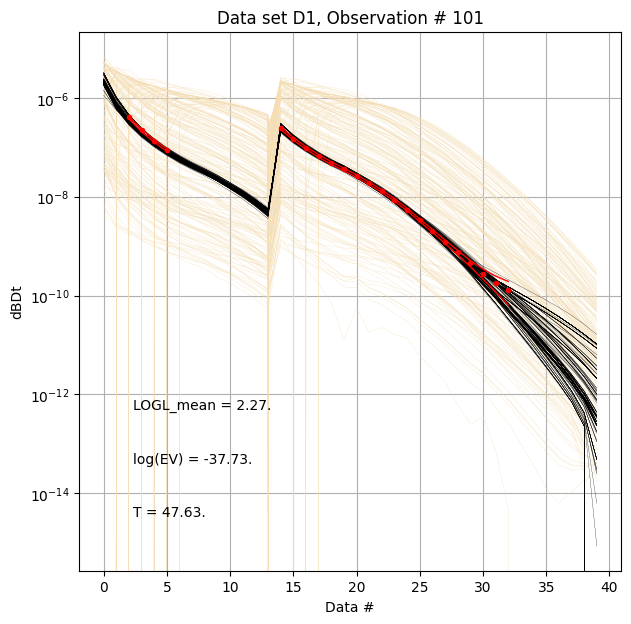

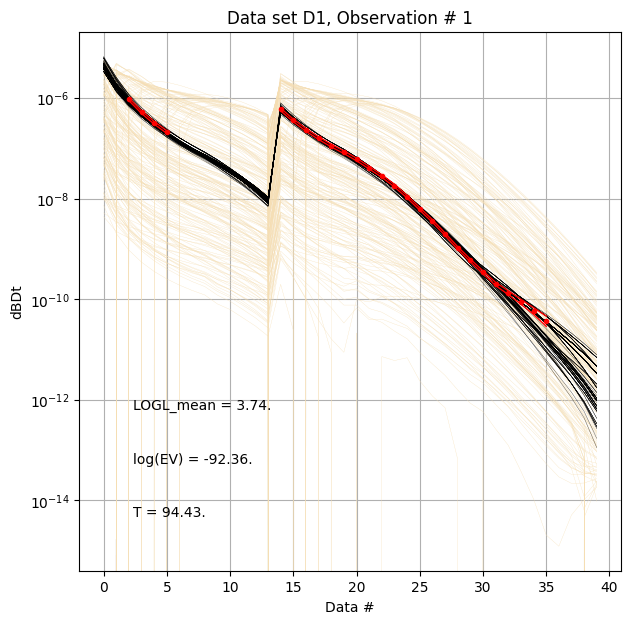

In [13]:
ig.plot_data_prior_post(f_post_h5, i_plot=100,hardcopy=hardcopy)
ig.plot_data_prior_post(f_post_h5, i_plot=0,hardcopy=hardcopy)

### Evidence and annealing temperature
The evidence quantifies how well the data fits the model,
while temperature controls the acceptance rate in rejection sampling.

Plot size: wx=10.000000, wy=7.752841


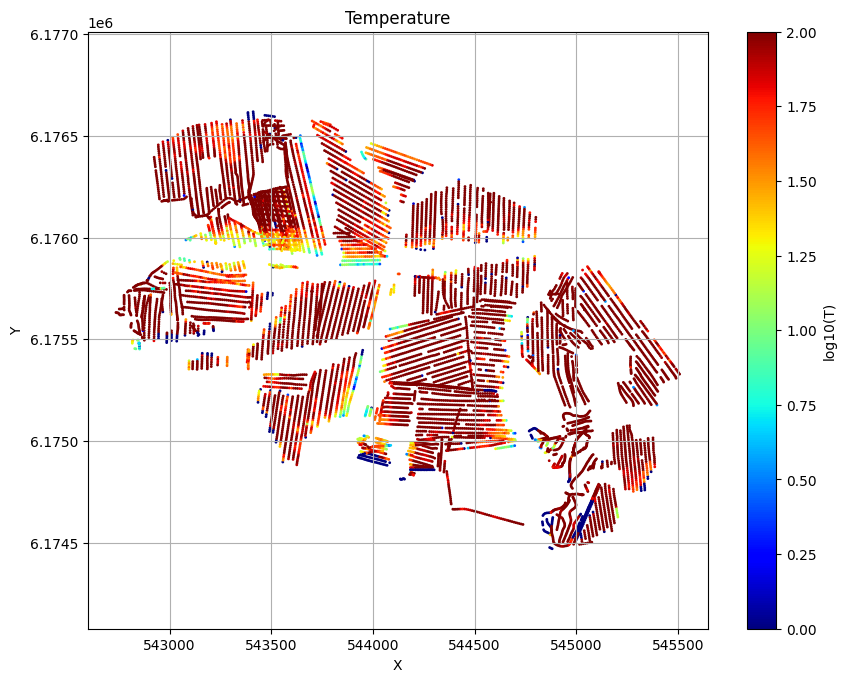

Plot size: wx=10.000000, wy=7.752841


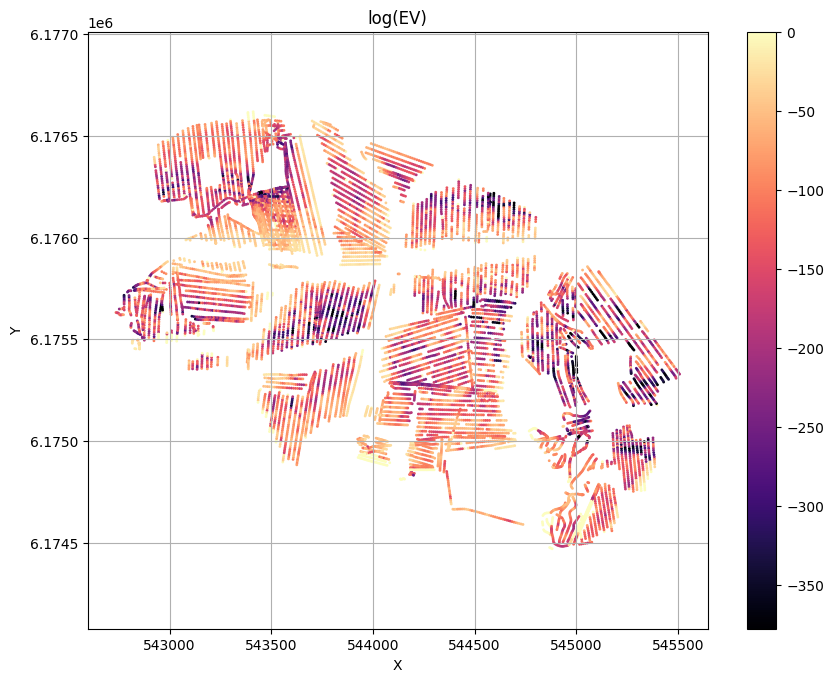

Plot size: wx=10.000000, wy=7.752841


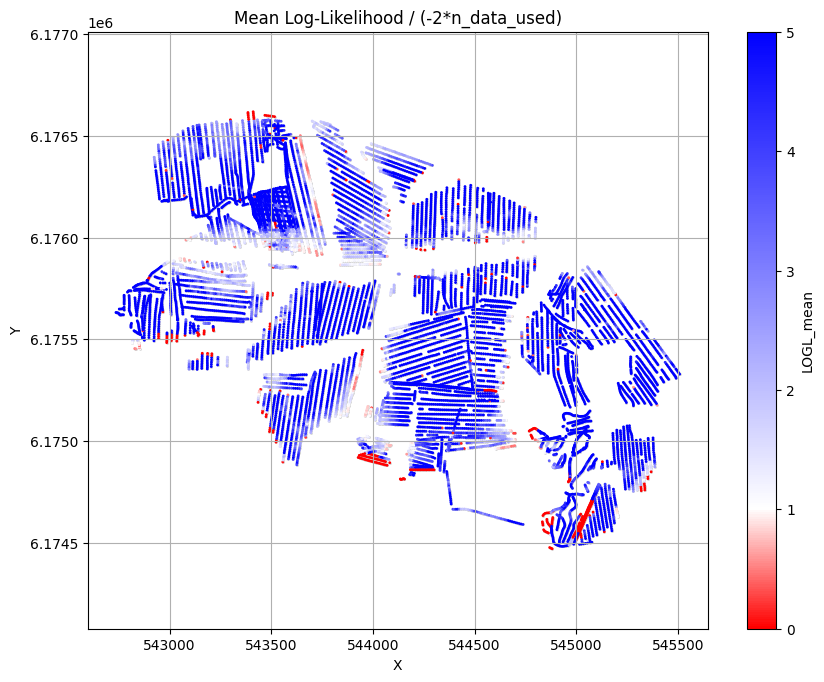

In [14]:
# Plot the annealing temperature used for inversion
ig.plot_T_EV(f_post_h5, pl='T',hardcopy=hardcopy)
# Plot the evidence (log-likelihood) estimated during inversion
ig.plot_T_EV(f_post_h5, pl='EV',hardcopy=hardcopy)
# Plot the normalized mean-loglikelihood
# Values less than one suggest overfitting
# Values above one suggest underfitting
ig.plot_T_EV(f_post_h5, pl='LOGL_mean',hardcopy=hardcopy)

### Resistivity profiles

Plot a profile showing posterior statistics of model parameter M1 (resistivity)
along a section of the survey line.

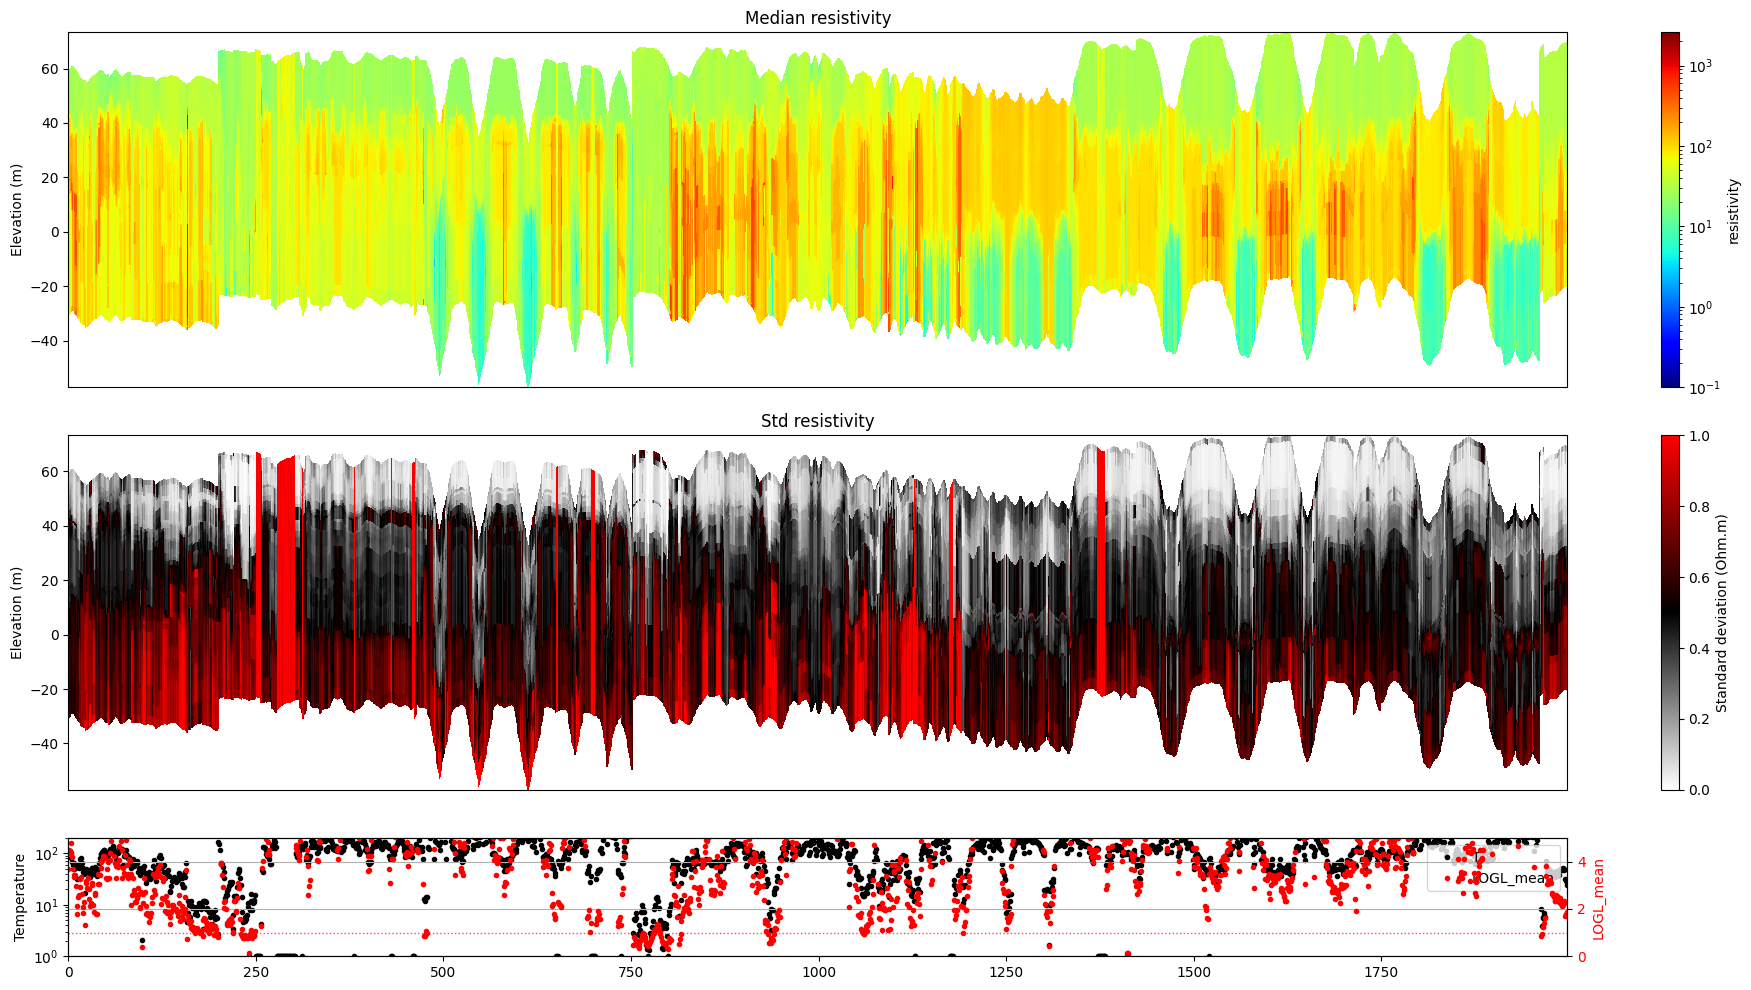

In [15]:
ig.plot_profile(f_post_h5, i1=1, i2=2000, im=1, hardcopy=hardcopy)

### Plot 2D spatial features

Plot the median resistivity at specific depths (layers 5, 30, and 50)
to show lateral variations in subsurface structure.

None


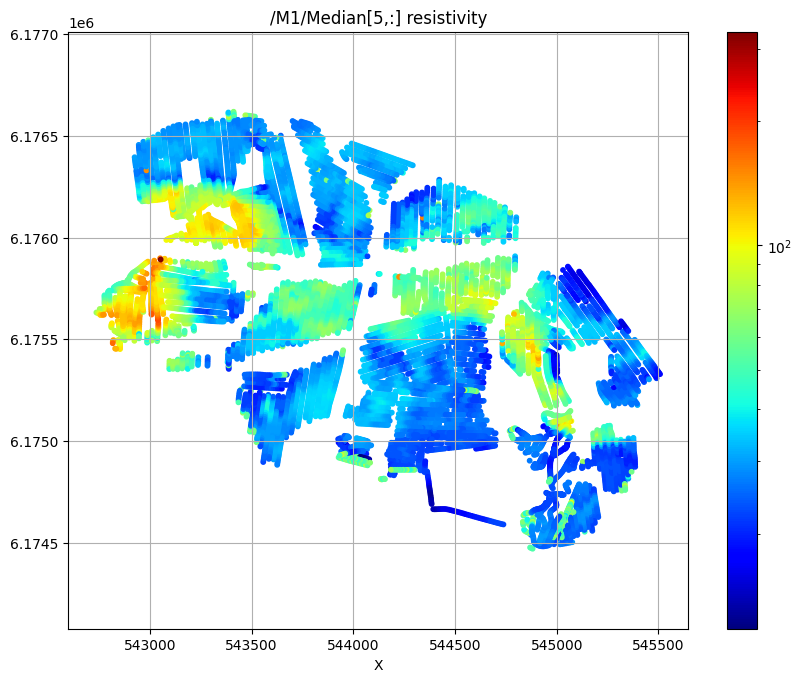

None


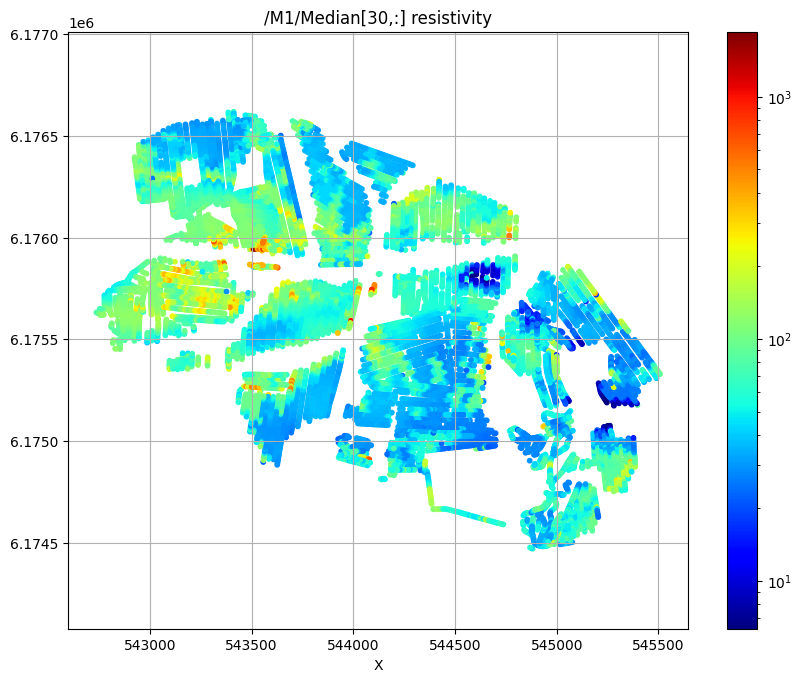

None


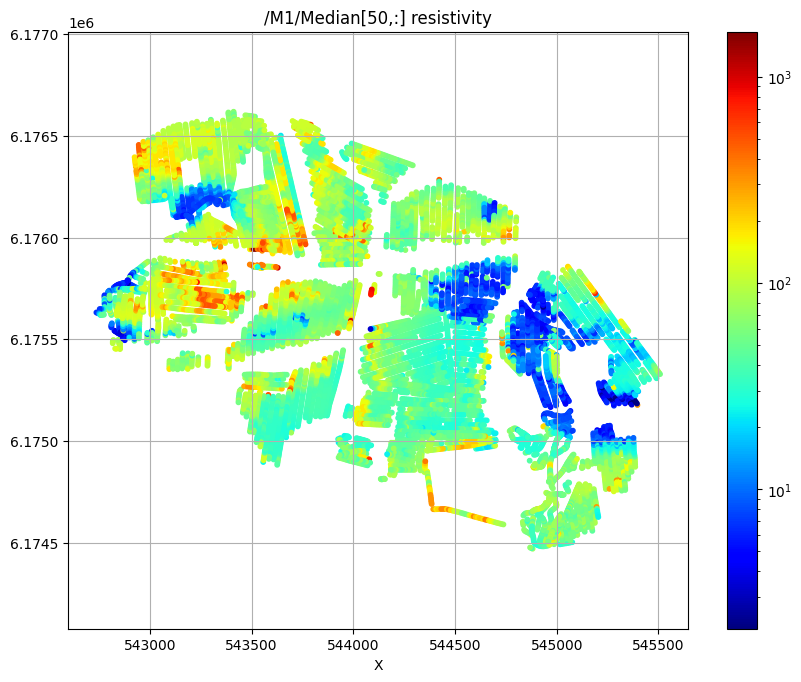

In [16]:

# Plot 2D features: Resistivity at different depths
try:
    ig.plot_feature_2d(f_post_h5,im=1,iz=5, key='Median', uselog=1, cmap='jet', s=10,hardcopy=hardcopy)
    plt.show()
except:
    pass

try:
    ig.plot_feature_2d(f_post_h5,im=1,iz=30, key='Median', uselog=1, cmap='jet', s=10,hardcopy=hardcopy)
    plt.show()
except:
    pass

try:
    ig.plot_feature_2d(f_post_h5,im=1,iz=50, key='Median', uselog=1, cmap='jet', s=10,hardcopy=hardcopy)
    plt.show()
except:
    pass

None


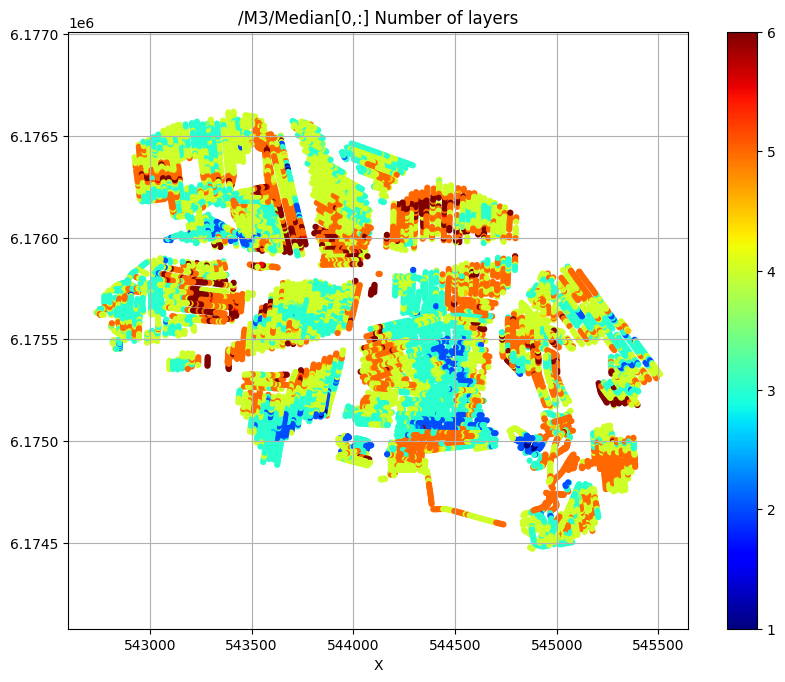

In [17]:
try:
    # Plot a 2D feature: The estimated number of layers
    ig.plot_feature_2d(f_post_h5,im=3,iz=0,key='Median', uselog=0, clim=[1,6], cmap='jet', s=12,hardcopy=hardcopy)
    plt.show()
except:
    pass

## Export results to CSV format
Export the posterior results to CSV files for use in GIS software or further analysis.

In [18]:
f_csv, f_point_csv = ig.post_to_csv(f_post_h5)

Writing to POST_M1.csv


----------------------------------------------------
Creating point data set: Median


Creating point data set: Mean


Creating point data set: Std


- saving to : POST_M1_point.csv


In [19]:
# Read the exported CSV file for inspection
# Example filename (actual filename will be generated automatically):
#f_point_csv = 'POST_DAUGAARD_AVG_PRIOR_CHI2_NF_3_log-uniform_N100000_TX07_20231016_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1_point.csv'
import pandas as pd
df = pd.read_csv(f_point_csv)
df.head()

X          Y      Z   LINE     Median       Mean       Std
0  543822.9  6176069.6  58.82  140.0  20.942810  20.161030  0.089583
1  543822.9  6176069.6  57.82  140.0  20.942810  20.263447  0.084603
2  543822.9  6176069.6  56.82  140.0  20.942810  20.604137  0.084285
3  543822.9  6176069.6  55.82  140.0  20.973934  20.995407  0.070722
4  543822.9  6176069.6  54.82  140.0  21.076424  21.589355  0.090120

In [20]:
# Optional: Use PyVista for 3D visualization of X,Y,Z coordinates with median resistivity
plPyVista = False
if plPyVista:
    import pyvista as pv
    import numpy as np
    from pyvista import examples
    #pv.set_jupyter_backend('client')
    pv.set_plot_theme("document")
    p = pv.Plotter(notebook=True)
    p = pv.Plotter()
    filtered_df = df[(df['Median'] < 50) | (df['Median'] > 200)]
    #filtered_df = df[(df['LINE'] > 1000) & (df['LINE'] < 1400) ]
    points = filtered_df[['X', 'Y', 'Z']].values[:]
    median = np.log10(filtered_df['Mean'].values[:])
    opacity = np.where(filtered_df['Median'].values[:] < 100, 0.5, 1.0)
    #p.add_points(points, render_points_as_spheres=True, point_size=3, scalars=median, cmap='jet', opacity=opacity)
    p.add_points(points, render_points_as_spheres=True, point_size=6, scalars=median, cmap='hot')
    p.show_grid()
    p.show()